In [1]:
!pip install -U scikit-learn
!pip install lightgbm
!pip install -U ml-research

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import sys

sys.path.append("..")

from itertools import product
from lightgbm import LGBMRanker
from sklearn.utils import check_random_state
from xai_ranking.benchmarks import (
    human_in_the_loop_experiment,
    human_in_the_loop_batch_experiment,
    hierarchical_ranking_explanation,
    hierarchical_ranking_batch_explanation,
    lime_experiment,
    lime_batch_experiment,
    shap_experiment,
    shap_batch_experiment,
    sharp_experiment,
    sharp_batch_experiment,
    # participation_experiment,
)
from xai_ranking.preprocessing import (
    preprocess_atp_data,
    preprocess_csrank_data,
    preprocess_higher_education_data,
    preprocess_movers_data,
    preprocess_synthetic_data,
)
from xai_ranking.datasets import (
    fetch_atp_data,
    fetch_csrank_data,
    fetch_higher_education_data,
    fetch_movers_data,
    fetch_synthetic_data,
)
from xai_ranking.scorers import (
    atp_score,
    csrank_score,
    higher_education_score,
    synthetic_equal_score_3ftrs,
)
from xai_ranking.metrics import (
    explanation_sensitivity, outcome_sensitivity,
    bootstrapped_explanation_consistency, cross_method_explanation_consistency,
    cross_method_outcome_consistency, explanation_sensitivity_all_neighbors
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlresearch.utils import check_random_states, set_matplotlib_style
from sharp.utils import scores_to_ordering

RNG_SEED = 42

In [2]:
# Set up ranker for the moving company dataset:
X, ranks, score = preprocess_movers_data(fetch_movers_data(test=False))
qids_train = X.index.value_counts().to_numpy()

model = LGBMRanker(
    objective="lambdarank", label_gain=list(range(max(ranks) + 1)), verbose=-1
)
model.fit(
    X=X,
    y=ranks,
    group=qids_train,
)

LGBMRanker(label_gain=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
           objective='lambdarank', verbose=-1)

In [3]:
# datasets = [
#     {
#         "name": "ATP",
#         "data": preprocess_atp_data(fetch_atp_data()),
#         "scorer": atp_score,
#     },
#     {
#         "name": "CSRank",
#         "data": preprocess_csrank_data(fetch_csrank_data()),
#         "scorer": csrank_score,
#     },
#     {
#         "name": "Higher Education",
#         "data": preprocess_higher_education_data(
#             fetch_higher_education_data(year=2020)
#         ),
#         "scorer": higher_education_score,
#     },
#     {
#         "name": "Moving Company",
#         "data": preprocess_movers_data(fetch_movers_data(test=True)),
#         "scorer": model.predict,
#     },
#     {
#         "name": "Synthetic_0",
#         "data": preprocess_synthetic_data(fetch_synthetic_data(synth_dt_version=0, item_num=1000)),
#         "scorer": synthetic_equal_score(feature_num=3),
#     },
#     {
#         "name": "Synthetic_1",
#         "data": preprocess_synthetic_data(fetch_synthetic_data(synth_dt_version=1, item_num=1000)),
#         "scorer": synthetic_equal_score(feature_num=3),
#     },
#     {
#         "name": "Synthetic_2",
#         "data": preprocess_synthetic_data(fetch_synthetic_data(synth_dt_version=2, item_num=1000)),
#         "scorer": synthetic_equal_score(feature_num=3),
#     },
# ]
datasets = [
    {
        "name": "Synthetic_0",
        "data": preprocess_synthetic_data(fetch_synthetic_data(synth_dt_version=0, item_num=1000)),
        "scorer": synthetic_equal_score_3ftrs,
    },
    {
        "name": "Synthetic_1",
        "data": preprocess_synthetic_data(fetch_synthetic_data(synth_dt_version=1, item_num=1000)),
        "scorer": synthetic_equal_score_3ftrs,
    },
    {
        "name": "Synthetic_2",
        "data": preprocess_synthetic_data(fetch_synthetic_data(synth_dt_version=2, item_num=1000)),
        "scorer": synthetic_equal_score_3ftrs,
    },
]


xai_methods = [
    {
        "iterations": 1,
        "name": "LIME",
        "experiment": lime_experiment,
        "kwargs": {"mode": "regression"}  # classification, regression
    },
    {
        "iterations": 1,
        "name": "SHAP",
        "experiment": shap_experiment,
        "kwargs": {}
    },
    {
        "iterations": 1,
        "name": "ShaRP",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            # "sample_size": 150,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": True,
            "qoi": "rank"
        }
    },
    {
        "iterations": 1,
        "name": "ShaRP",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            # "sample_size": 150,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": True,
            "qoi": "score"
        }
    },
    {
        "iterations": 1,
        "name": "HRE",
        "experiment": hierarchical_ranking_explanation,
        "kwargs": {
            "model_type": "OLS",  # DT, LR, OLS, PLS
            "s": 5
        }
    },
    {
        "iterations": 1,
        "name": "HIL",
        "experiment": human_in_the_loop_experiment,
        "kwargs": {"upper_bound": 1, "lower_bound": None}
    },
    # {"iterations": 1, "name": "Participation", "experiment": participation_experiment},
]

# xai_methods = [
#     {
#         "iterations": 1,
#         "name": "HRE",
#         "experiment": hierarchical_ranking_explanation,
#         "kwargs": {
#             "model_type": "OLS",  # DT, LR, OLS, PLS
#             "s": 5
#         }
#     },
#     {
#         "iterations": 10,
#         "name": "BATCH_HRE",
#         "experiment": hierarchical_ranking_batch_explanation,
#         "kwargs": {
#             "model_type": "OLS",  # DT, LR, OLS, PLS
#             "s": 5
#         }
#     },
#     {
#         "iterations": 1,
#         "name": "HIL",
#         "experiment": human_in_the_loop_experiment,
#         "kwargs": {"upper_bound": 1, "lower_bound": None}
#     },
#     {
#         "iterations": 10,
#         "name": "BATCH_HIL",
#         "experiment": human_in_the_loop_batch_experiment,
#         "kwargs": {"upper_bound": 1, "lower_bound": None}
#     }
# ]

total_states = sum(map(lambda x: x["iterations"], xai_methods)) * len(datasets)
random_states = (x for x in check_random_states(RNG_SEED, total_states))

In [4]:
results = {}
for dataset in datasets:
    results[dataset["name"]] = {}
    for xai_method in xai_methods:
        results[dataset["name"]][xai_method["name"]] = []

        experiment_func = xai_method["experiment"]
        score_func = dataset["scorer"]

        X, ranks, scores = dataset["data"]

        print(xai_method["name"])
        print(type(X))
        print(score_func)

        for iteration_idx in range(xai_method["iterations"]):
            random_state = next(random_states)
            if "done" in dataset and dataset["done"]:
                continue

            kwargs = {} if "kwargs" not in xai_method else xai_method["kwargs"]
            if dataset["name"] == "Moving Company" and xai_method["name"].endswith("ShaRP"):
                kwargs["sample_size"] = 150

            contributions = experiment_func(X, score_func, random_state=random_state, **kwargs)

            results[dataset["name"]][xai_method["name"]].append(contributions)
            result_df = pd.DataFrame(contributions, columns=X.columns, index=X.index)
            result_df.to_csv(
                f"results/_contributions_{dataset['name']}_{xai_method['name']}_{iteration_idx}.csv"
            )

LIME
<class 'pandas.core.frame.DataFrame'>
<function synthetic_equal_score_3ftrs at 0x14ba3b9258a0>
SHAP
<class 'pandas.core.frame.DataFrame'>
<function synthetic_equal_score_3ftrs at 0x14ba3b9258a0>


KeyboardInterrupt: 

In [4]:
def read_results_from_files():
    return_dict = {}
    for cur_dataset in datasets:
        return_dict[cur_dataset["name"]] = {}
        for cur_xai_method in xai_methods:
            return_dict[cur_dataset["name"]][cur_xai_method["name"]] = []
            for iteration in range(cur_xai_method["iterations"]):
                fname = (
                    f"results/_contributions_"
                    f"{cur_dataset['name']}_{cur_xai_method['name']}_"
                    f"{iteration}.csv"
                )
                if os.path.isfile(fname):
                    (
                        return_dict[cur_dataset["name"]][cur_xai_method["name"]].append(
                            pd.read_csv(fname, index_col=0)
                        )
                    )
    return return_dict

In [5]:
results = read_results_from_files()

In [6]:
results

{'ATP': {'LIME': [                         serve__pct_1st_serve  \
   player_name                                     
   John Isner                           5.728773   
   Nick Kyrgios                         5.980128   
   Reilly Opelka                        2.125014   
   Hubert Hurkacz                      -1.214858   
   Matteo Berrettini                    1.588932   
   ...                                       ...   
   Diego Schwartzman                    6.173668   
   Fabio Fognini                       -5.659780   
   Cristian Garin                      -1.388583   
   Bernabe Zapata Miralles              1.928366   
   Nikoloz Basilashvili                -5.861706   
   
                            serve__pct_1st_serve_points_won  \
   player_name                                                
   John Isner                                      8.373206   
   Nick Kyrgios                                    8.396664   
   Reilly Opelka                                   8.

# Explanation Sensitivity

In [7]:
help(explanation_sensitivity)

Help on function explanation_sensitivity in module xai_ranking.metrics._sensitivity:

explanation_sensitivity(original_data, contributions, rankings, n_neighbors=10, agg_type='mean', measure='kendall', similar_outcome=True, **kwargs)



In [14]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

expl_sens_res = {}
expl_sens_sem = {}
for method in methods:
    expl_sens_res[method] = {}
    expl_sens_sem[method] = {}
    for dataset in datasets:
        try:
            rankings = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
            result = explanation_sensitivity(
                dataset["data"][0], 
                results[dataset["name"]][method][0],
                rankings,
                measure="jaccard"
            )
            expl_sens_res[method][dataset["name"]] = result[0]
            expl_sens_sem[method][dataset["name"]] = result[1]
        except:
            pass

In [15]:
pd.DataFrame(expl_sens_res)

Empty DataFrame
Columns: [HRE, HIL]
Index: []

## Reverse explanation sensitivity

In [14]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

expl_sens_res = {}
expl_sens_sem = {}
for method in methods:
    expl_sens_res[method] = {}
    expl_sens_sem[method] = {}
    for dataset in datasets:
        try:
            rankings = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
            result = explanation_sensitivity(
                dataset["data"][0], 
                results[dataset["name"]][method][0],
                rankings,
                measure="jaccard",
                n_features=0.8,
                similar_outcome = False
            )
            expl_sens_res[method][dataset["name"]] = result[0]
            expl_sens_sem[method][dataset["name"]] = result[1]
        except:
            pass

pd.DataFrame(expl_sens_res)

## Explanation Sensitivity Plot

In [8]:
import seaborn as sns

86


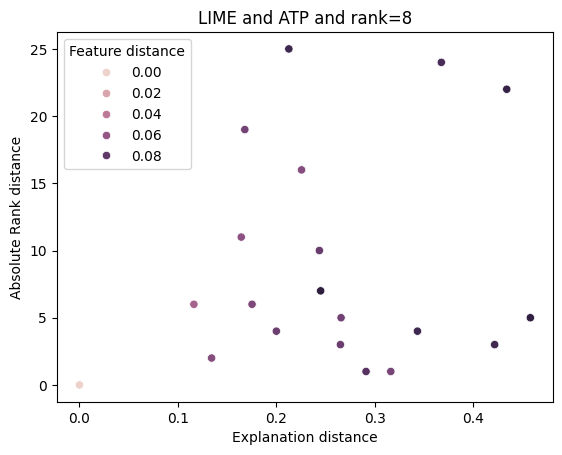

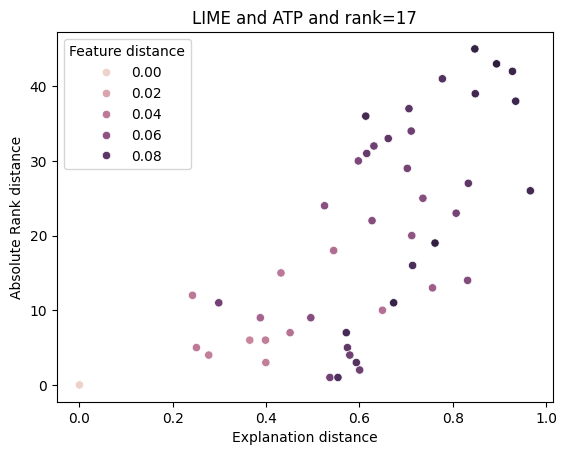

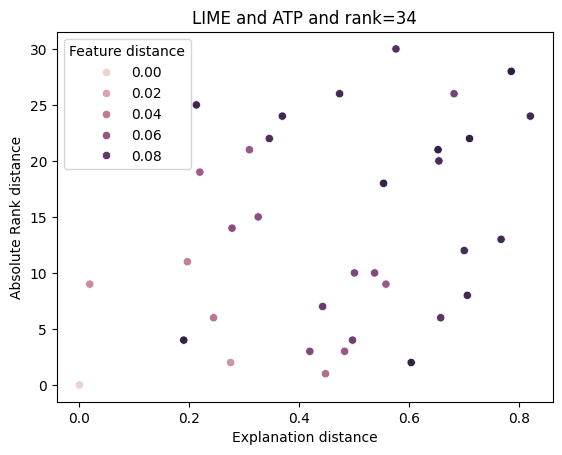

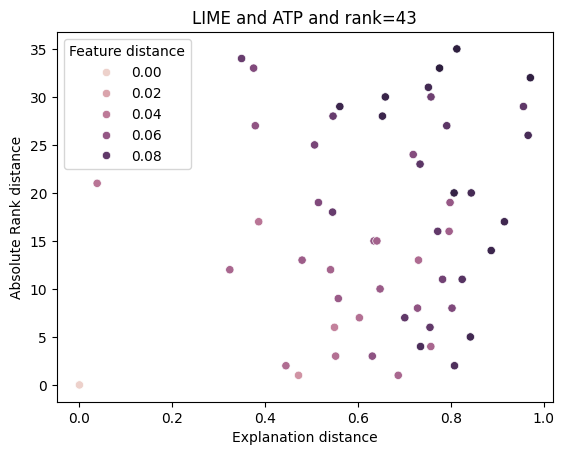

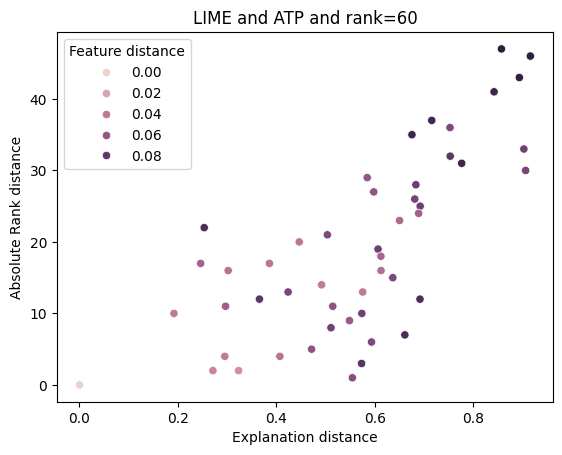

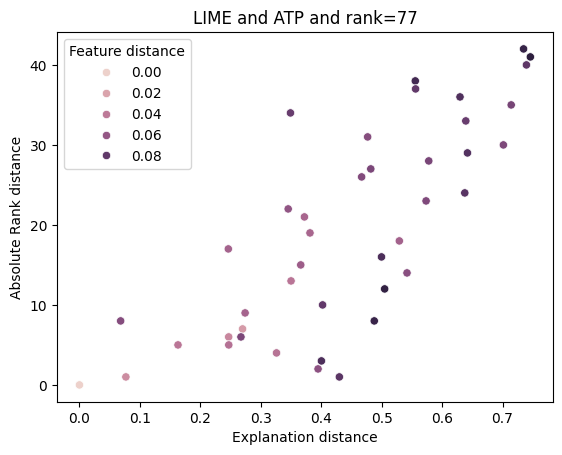

189


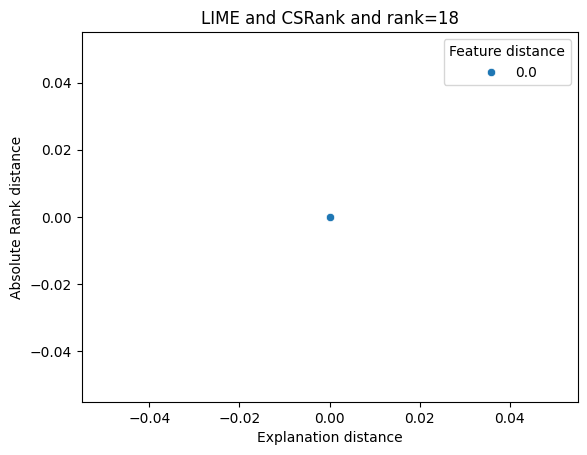

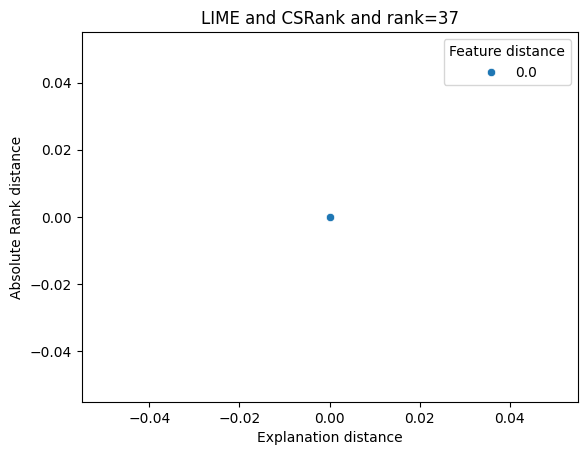

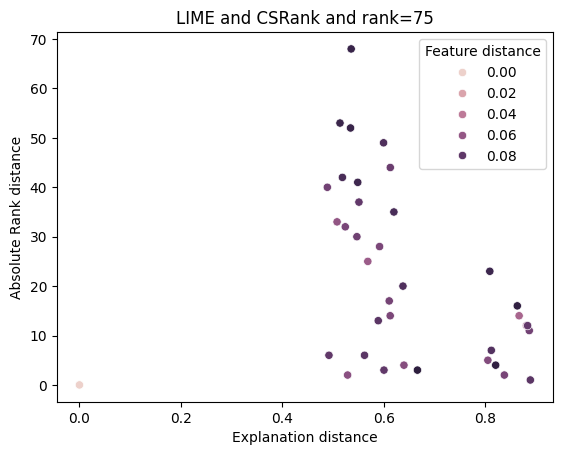

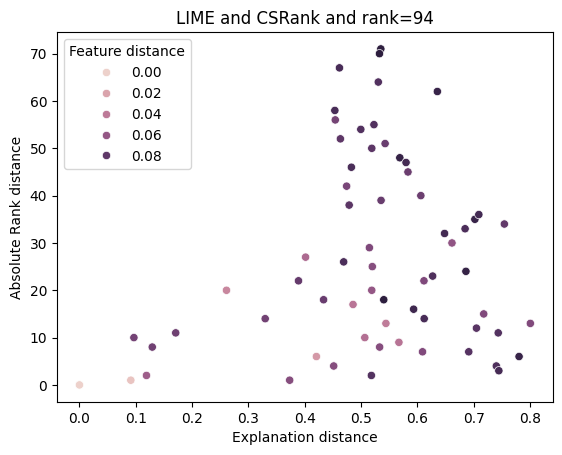

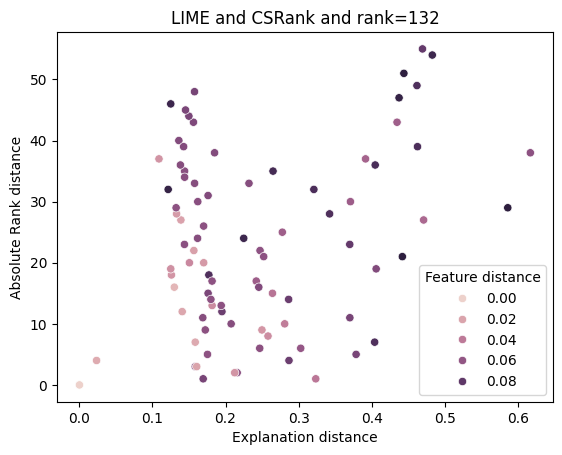

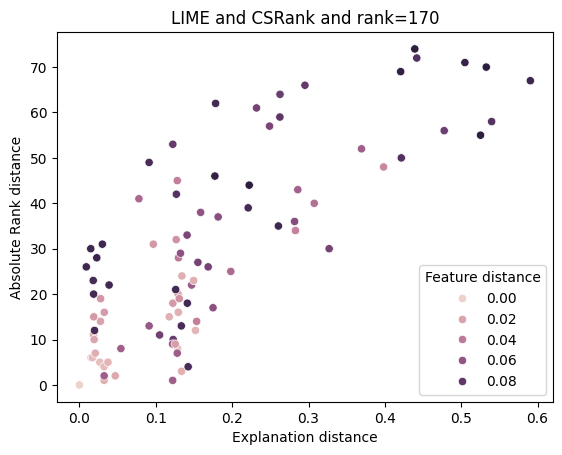

1397


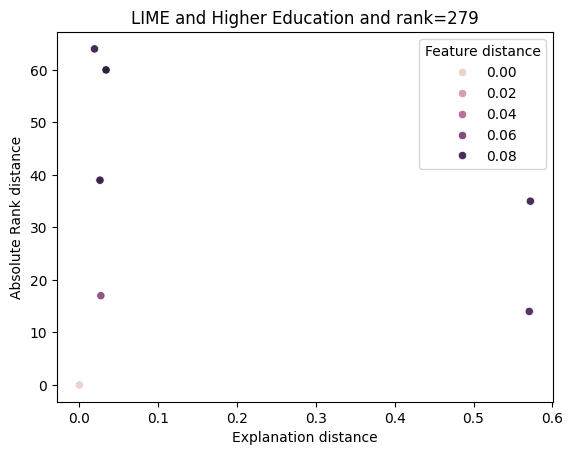

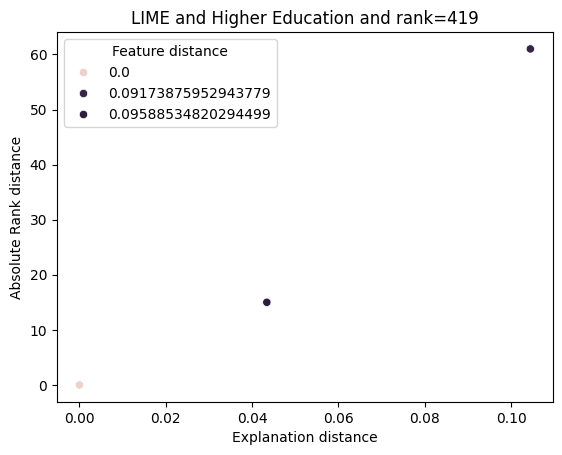

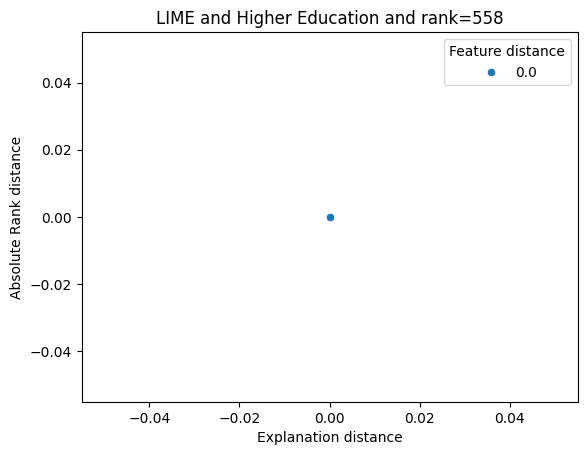

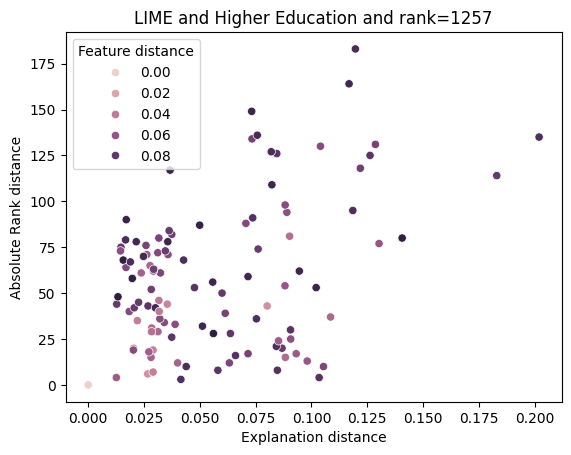

2000


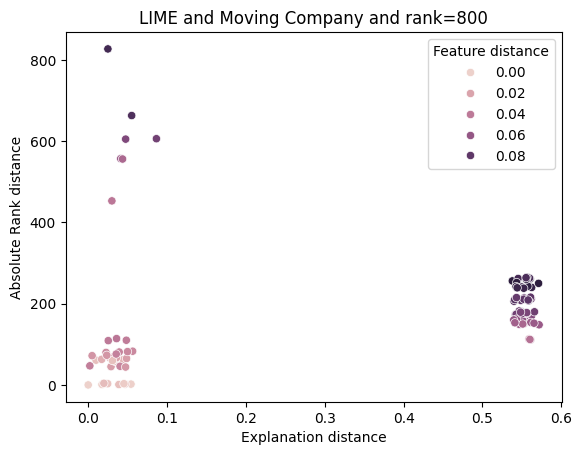

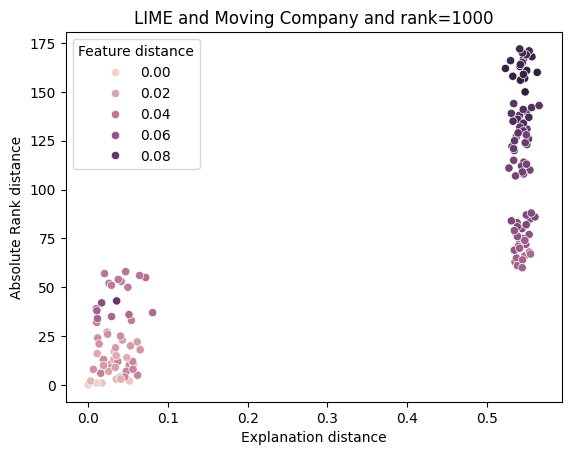

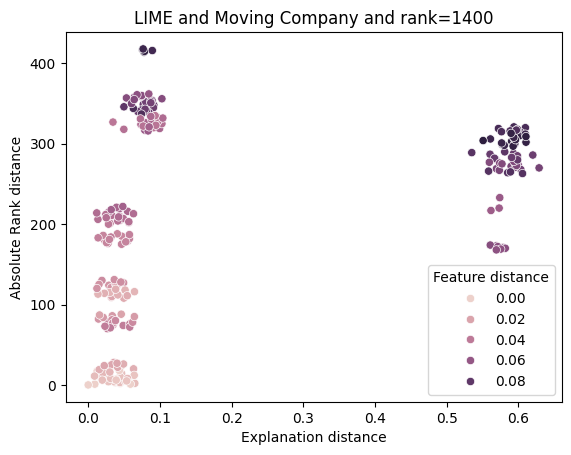

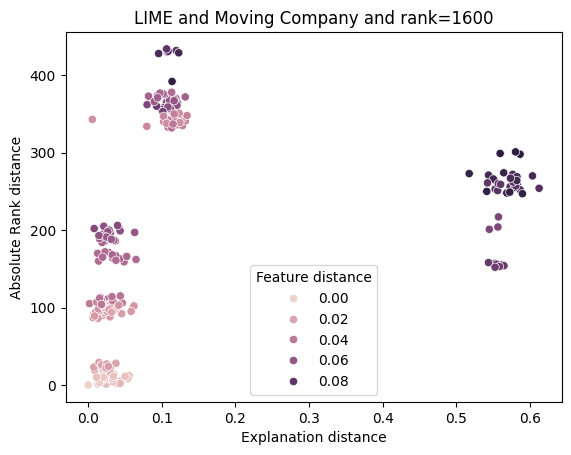

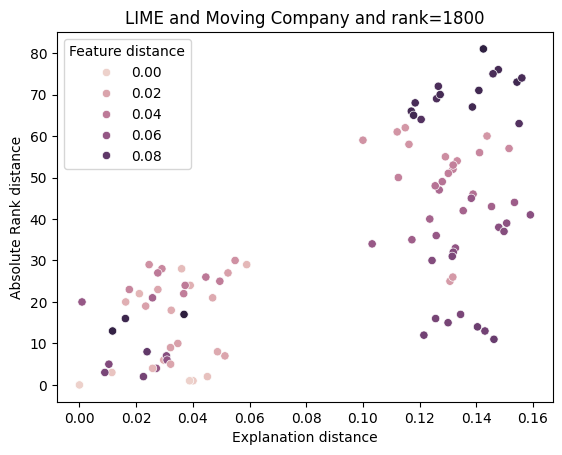

86


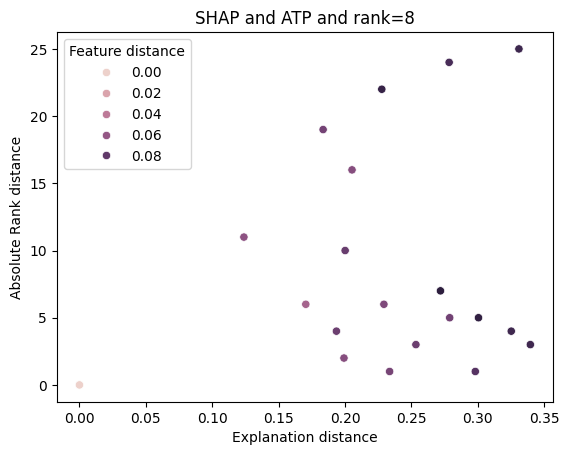

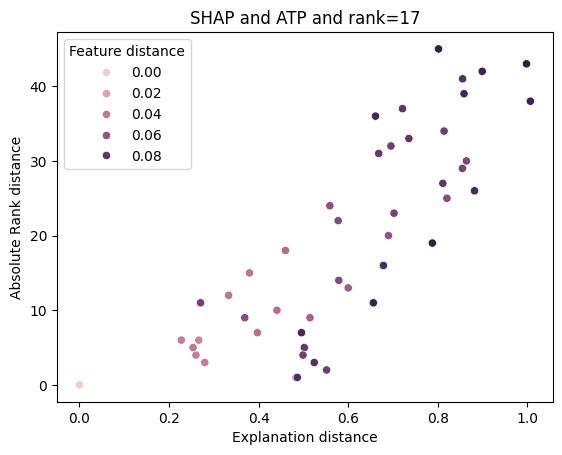

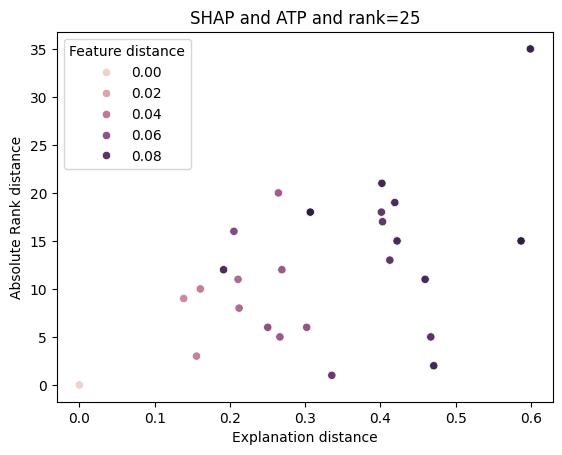

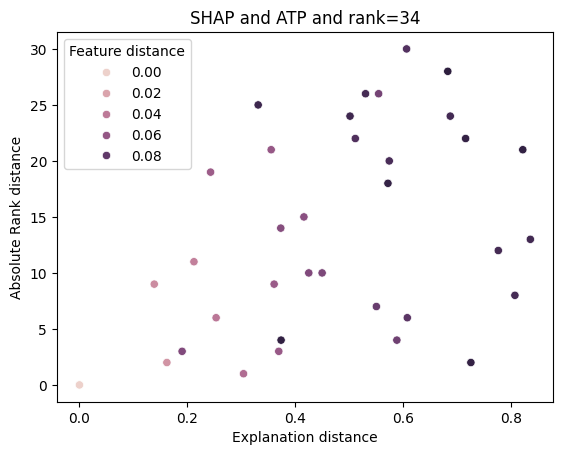

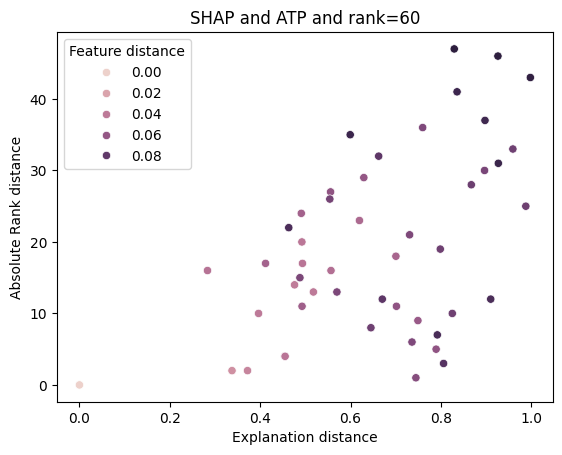

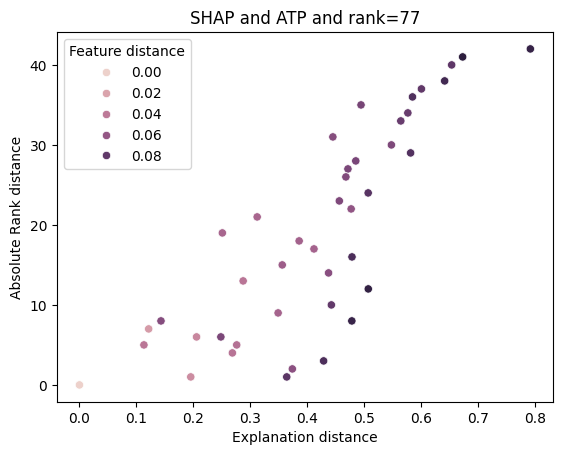

189


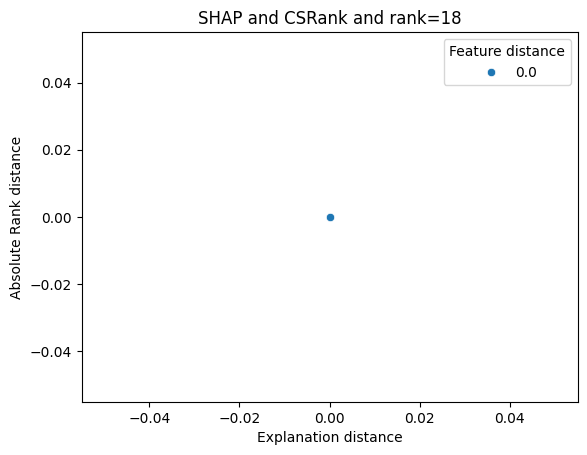

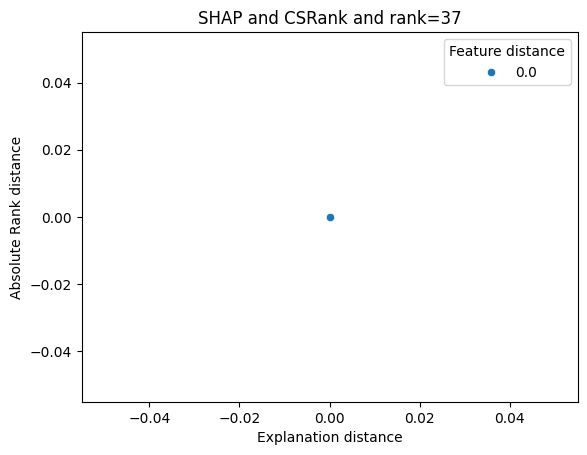

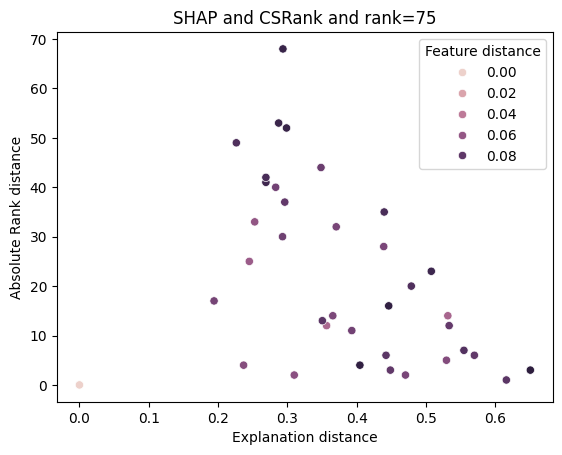

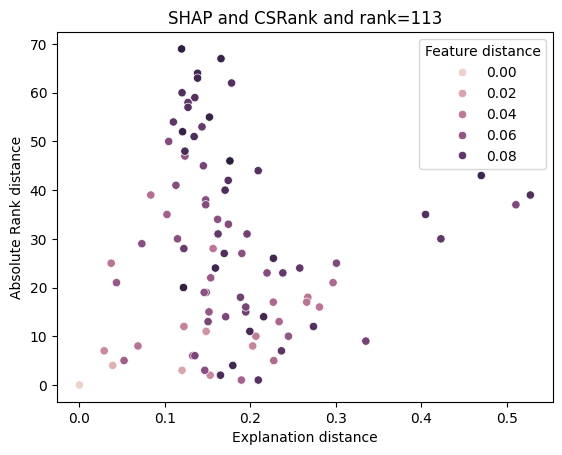

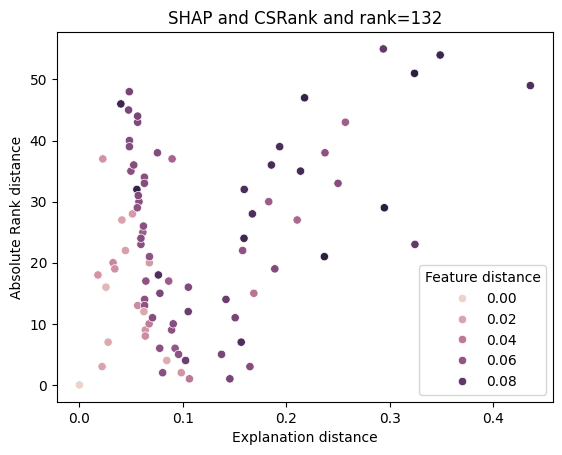

1397


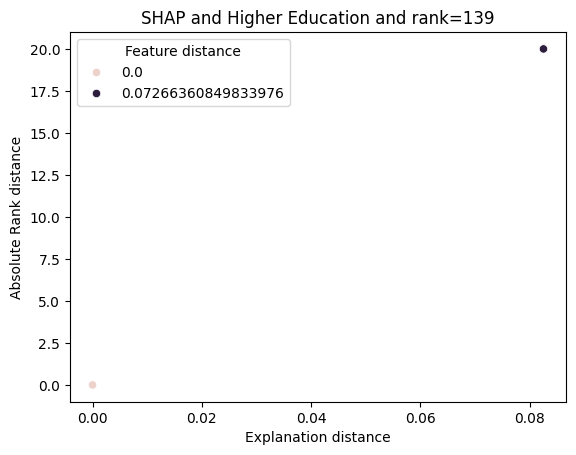

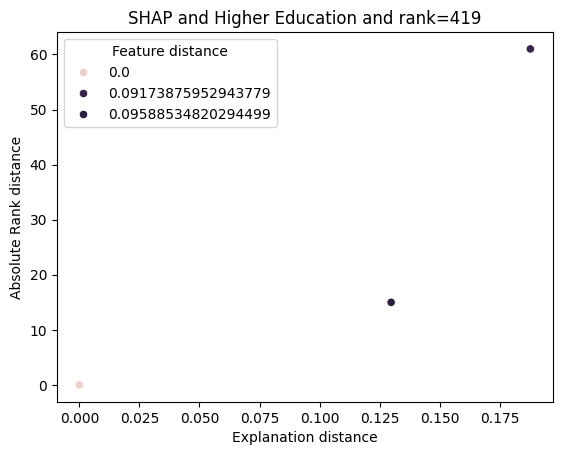

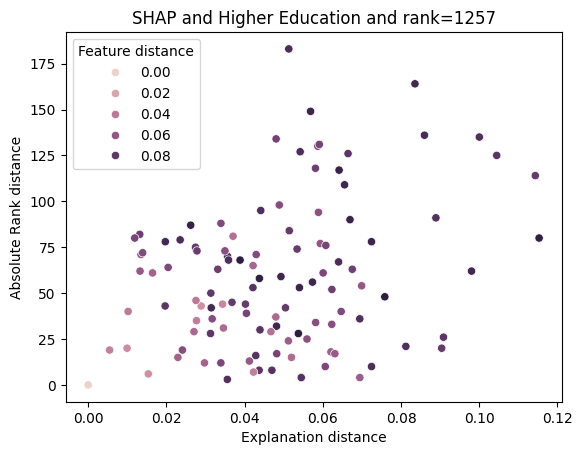

2000


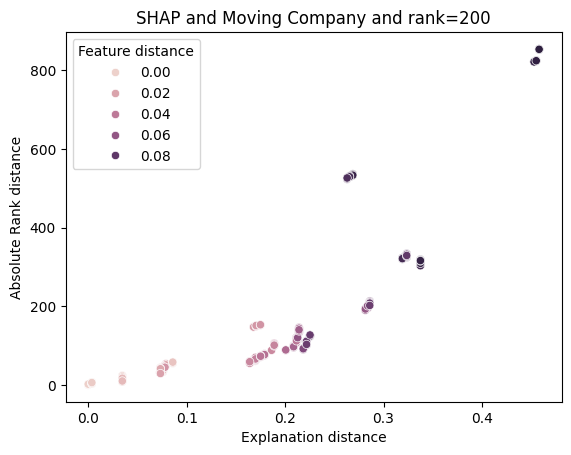

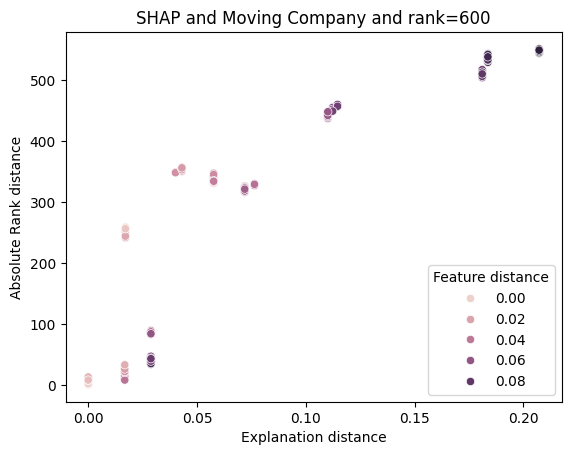

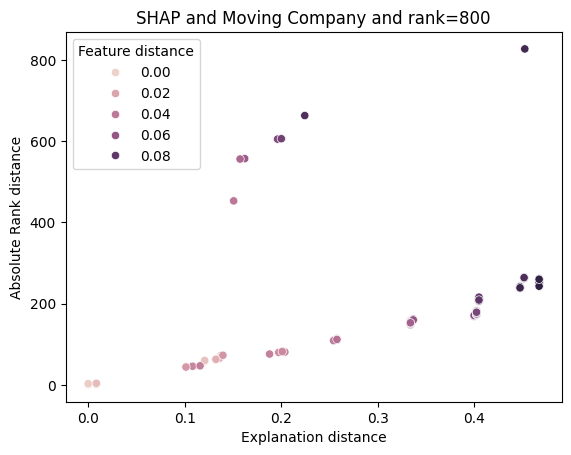

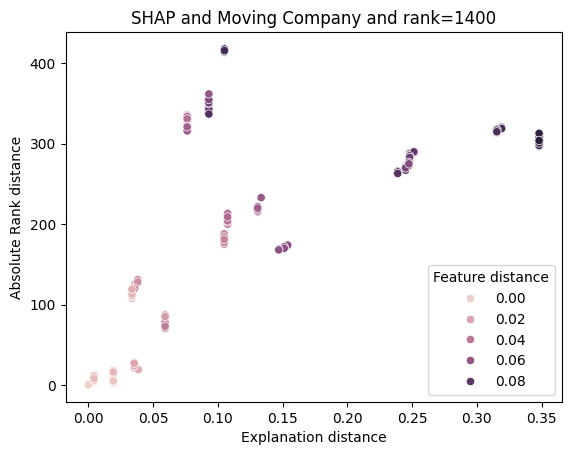

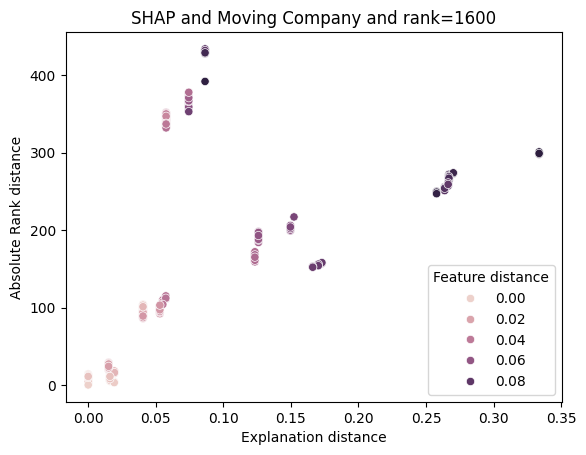

86


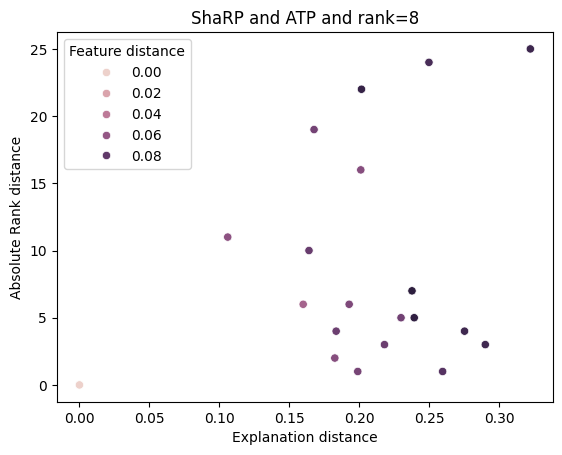

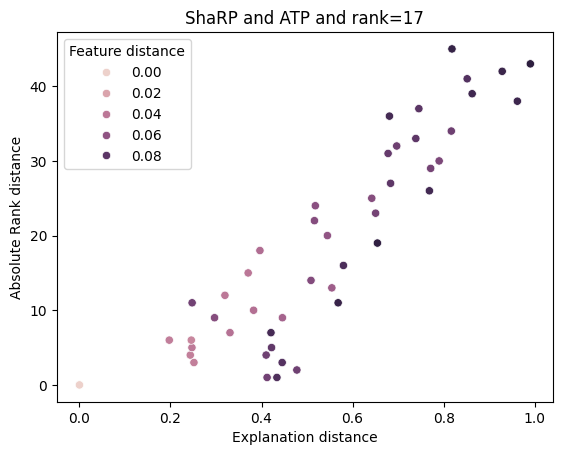

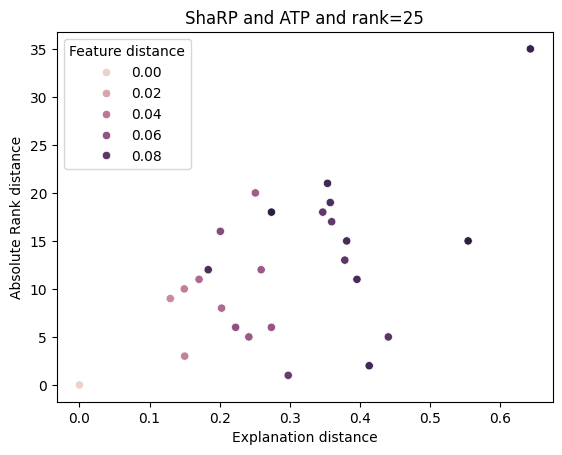

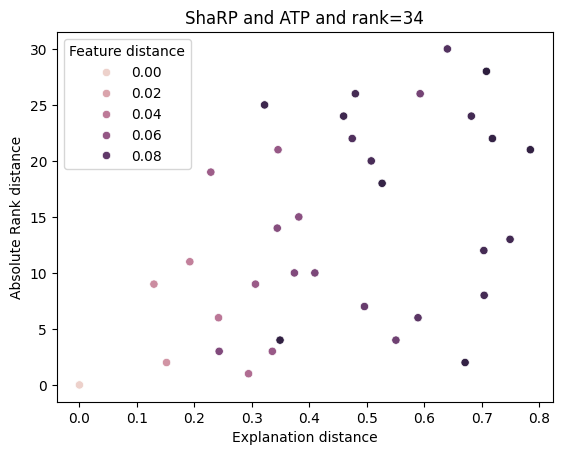

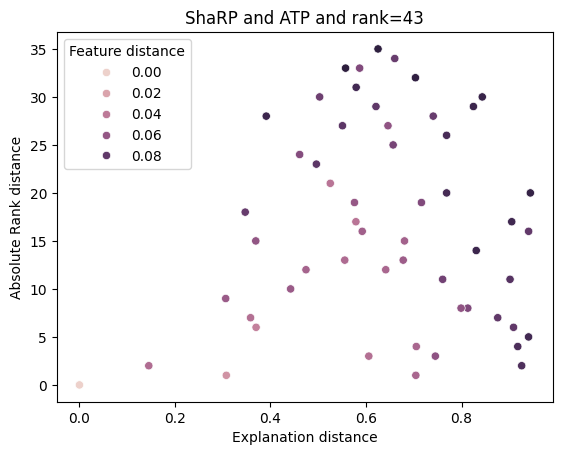

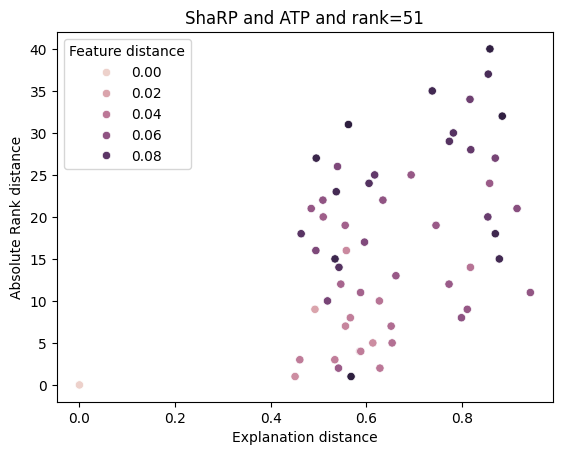

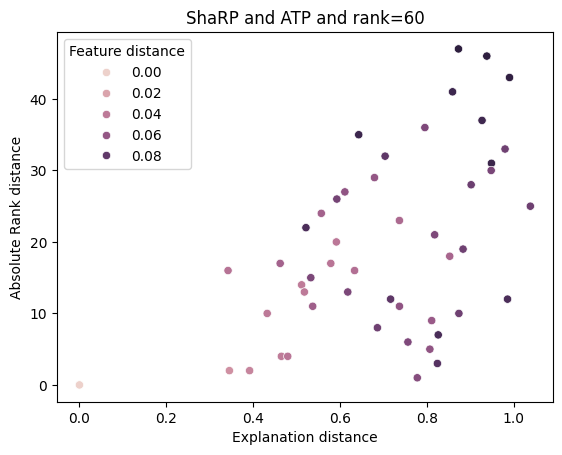

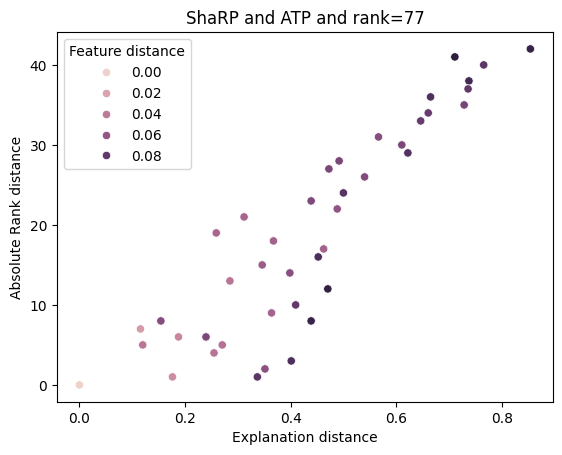

189


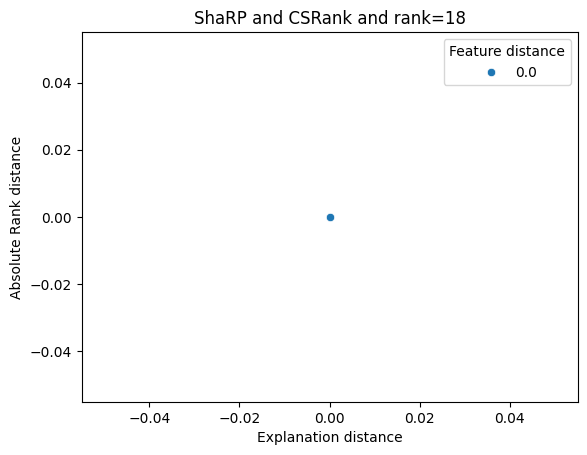

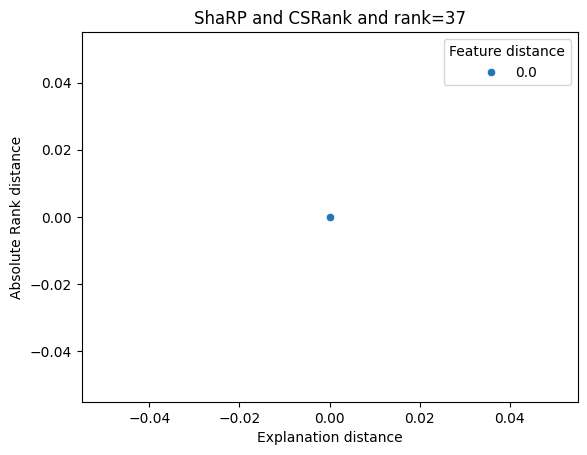

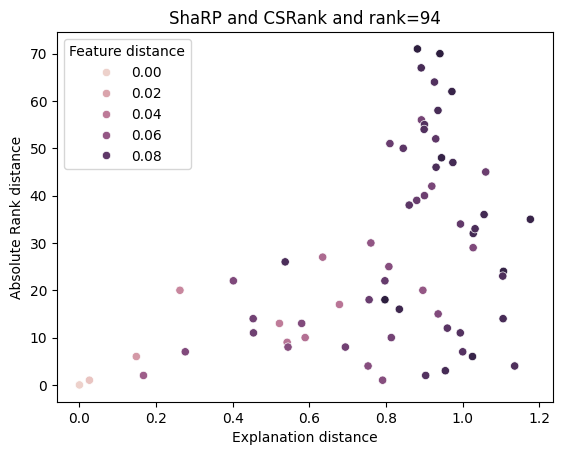

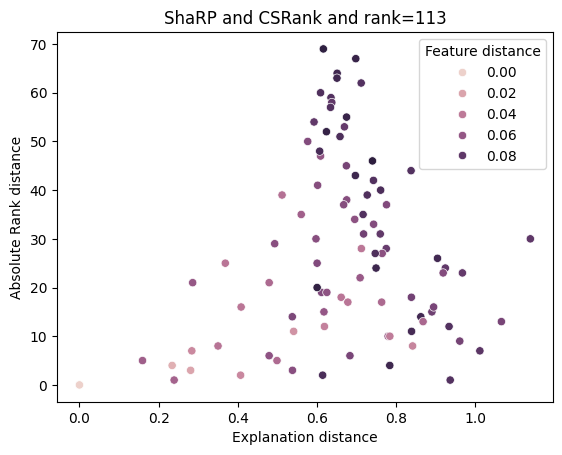

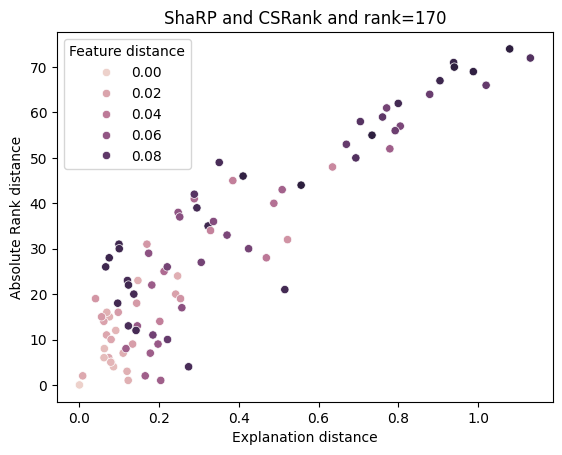

1397


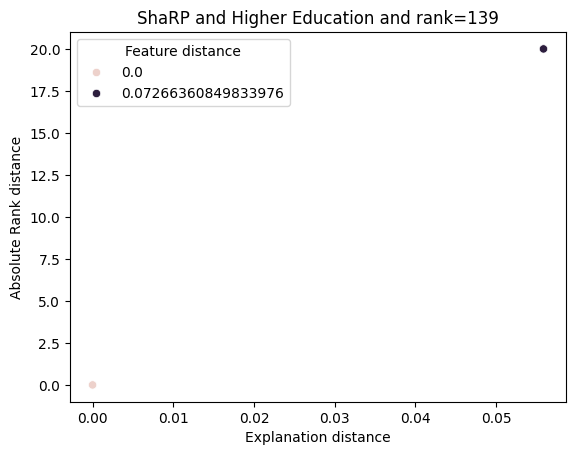

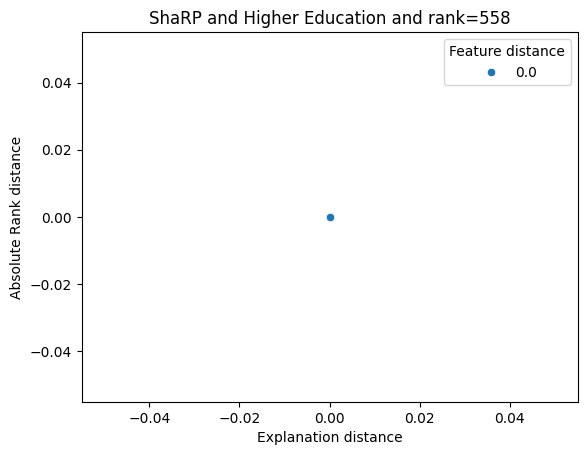

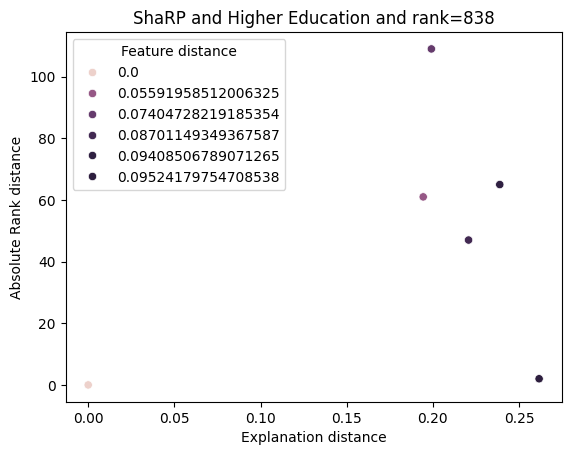

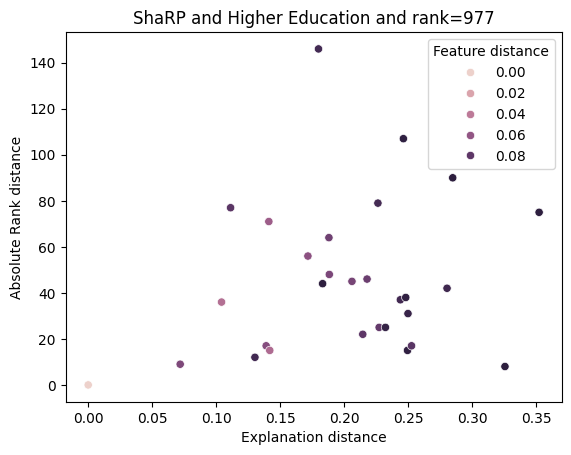

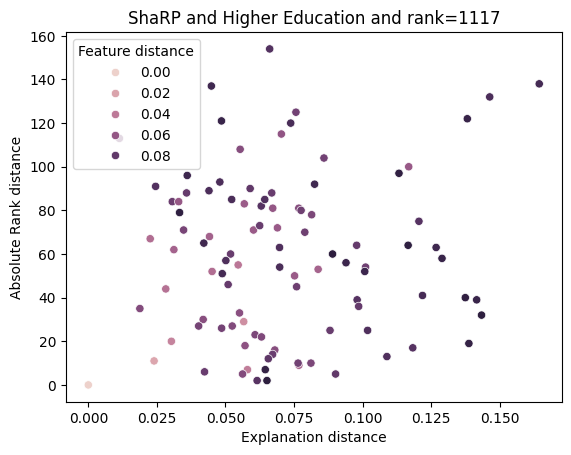

2000


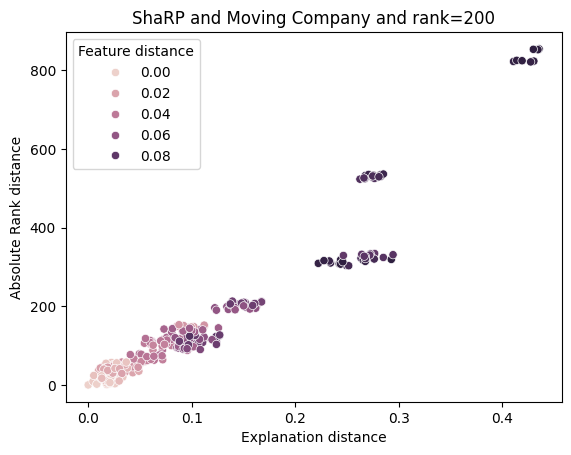

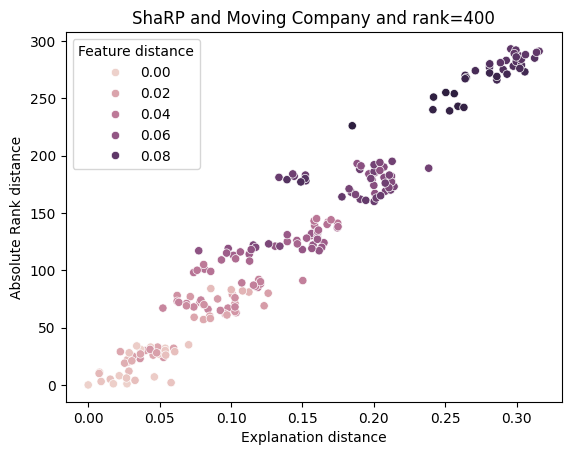

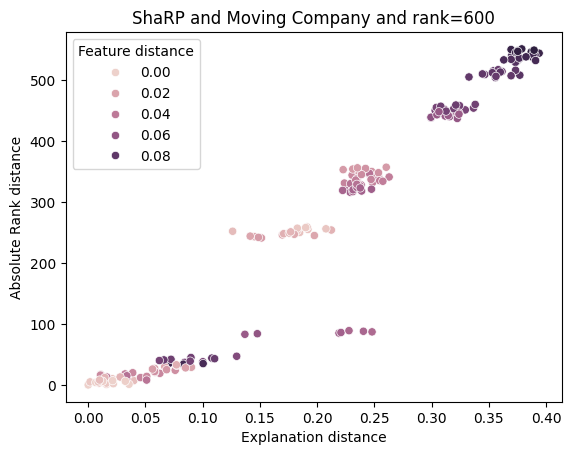

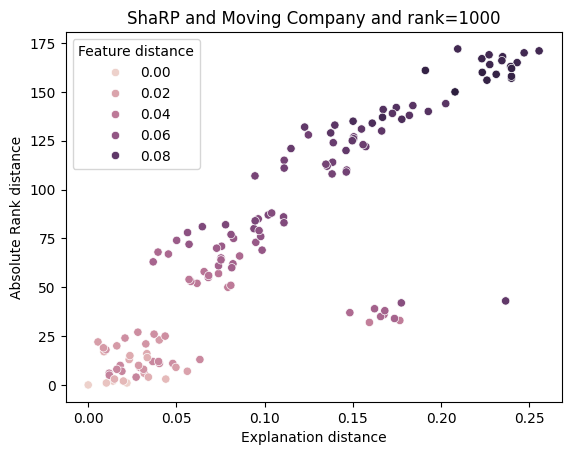

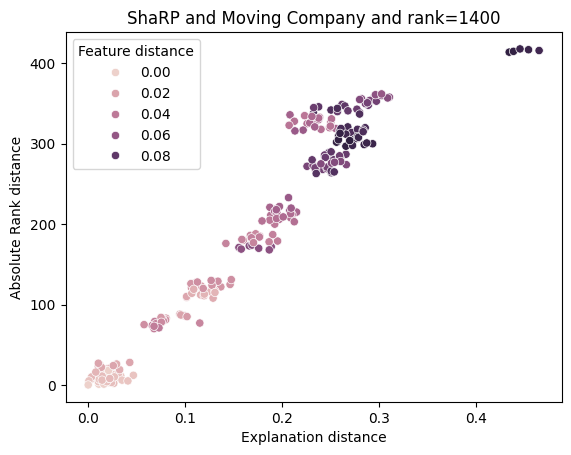

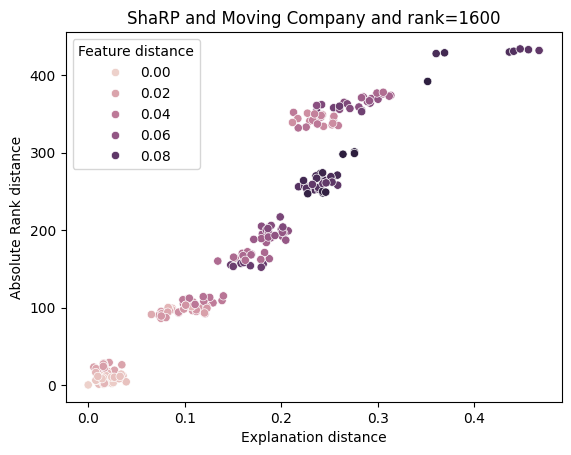

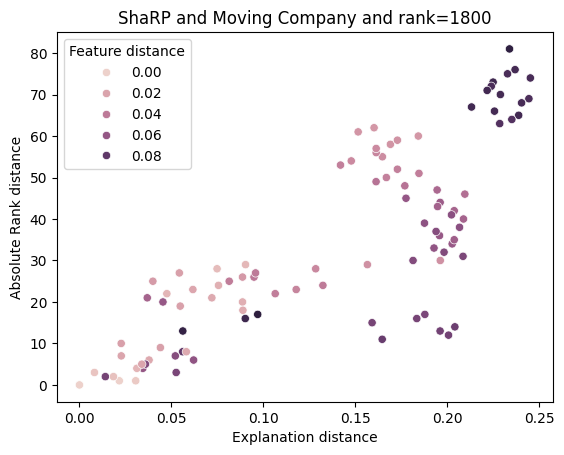

86


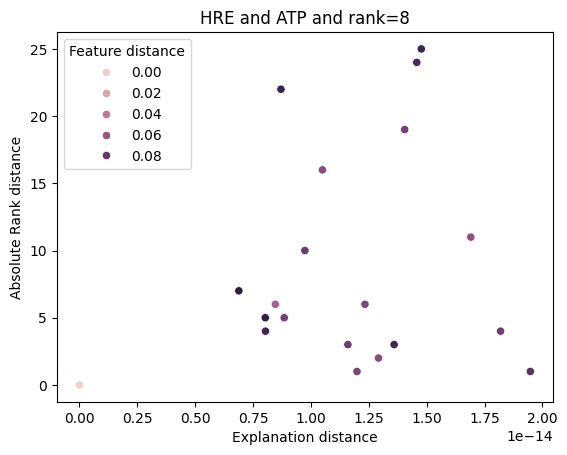

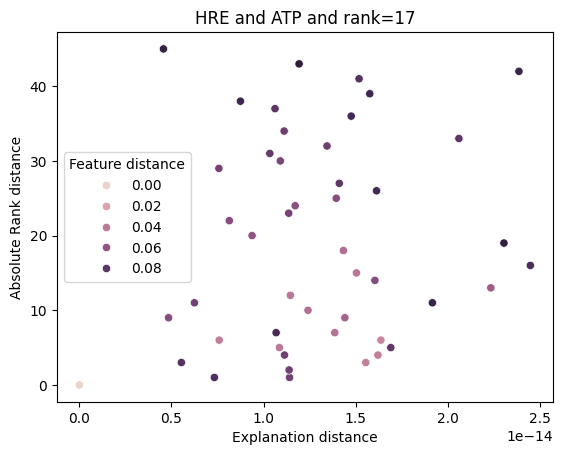

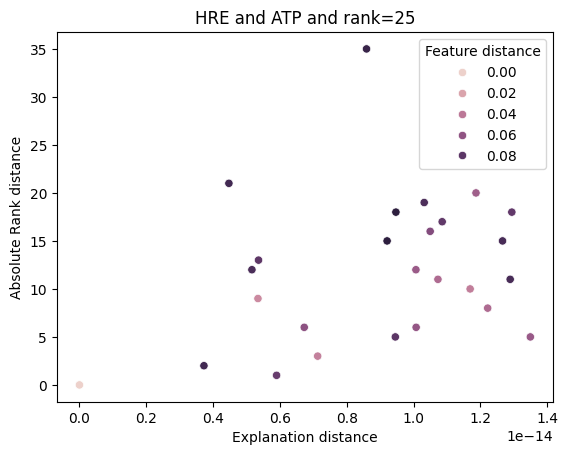

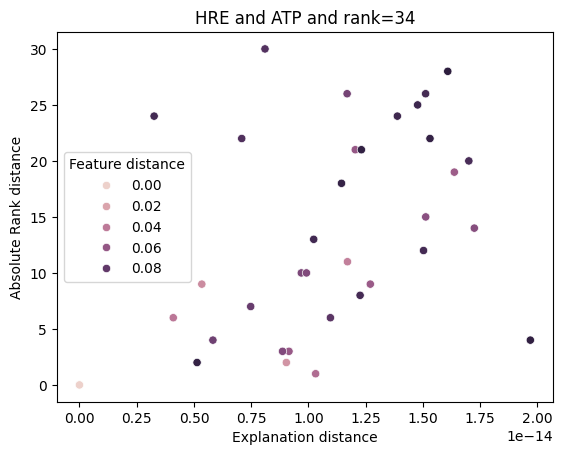

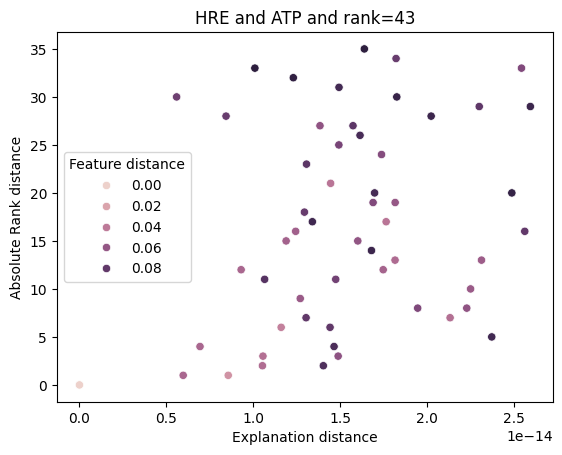

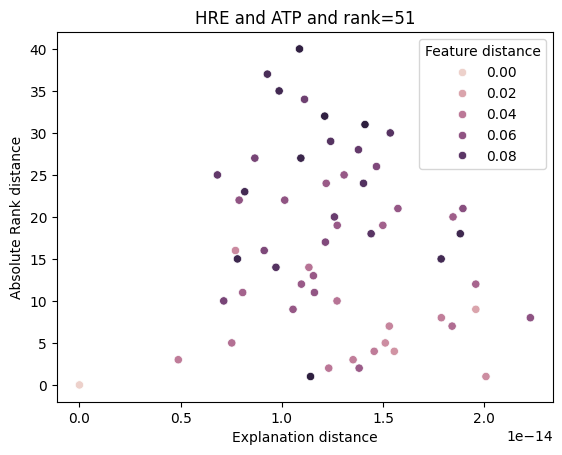

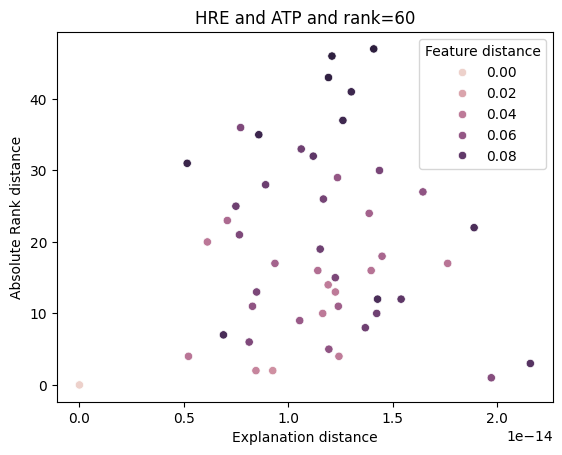

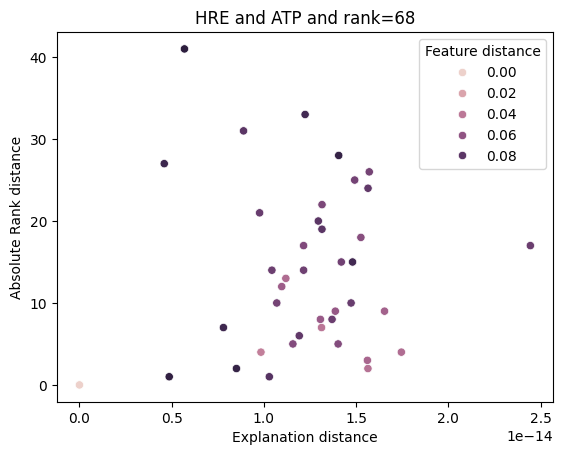

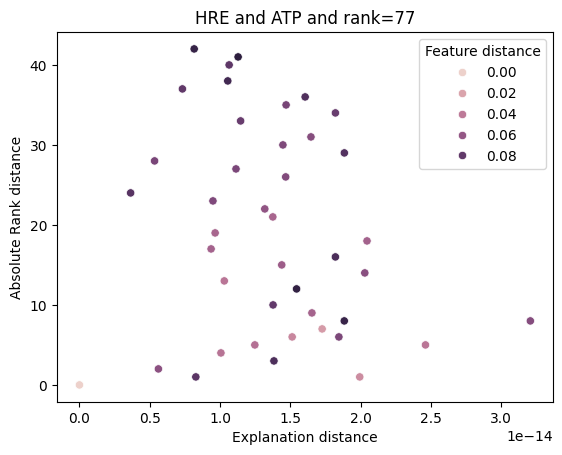

189


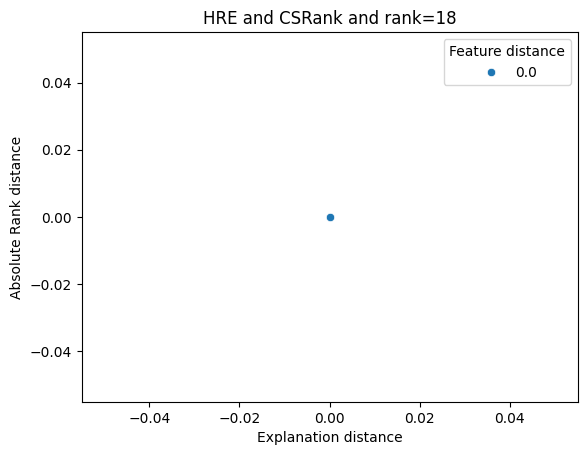

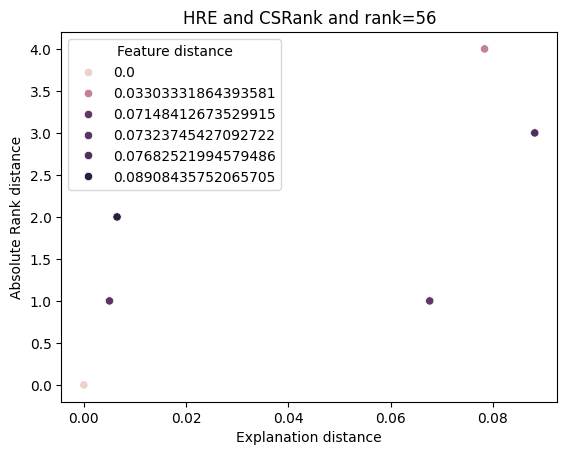

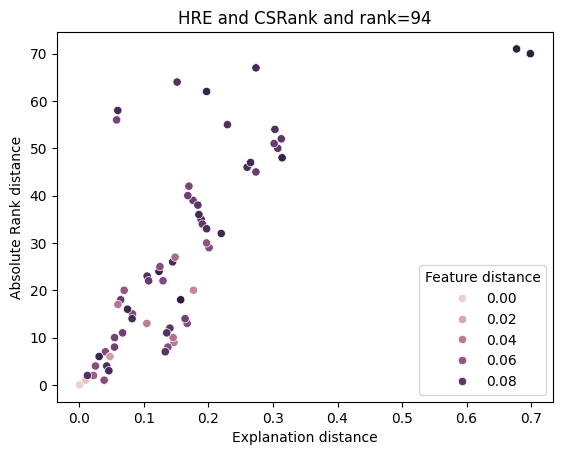

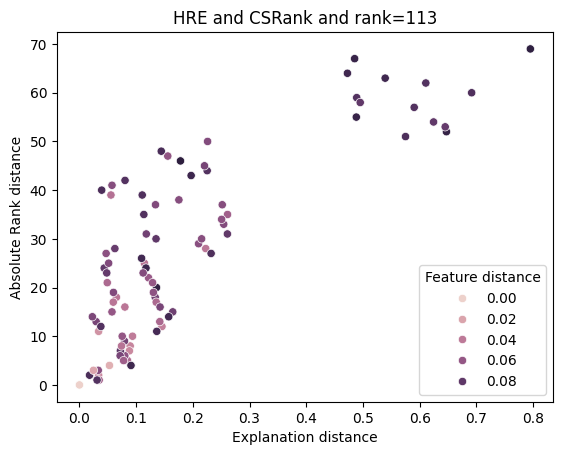

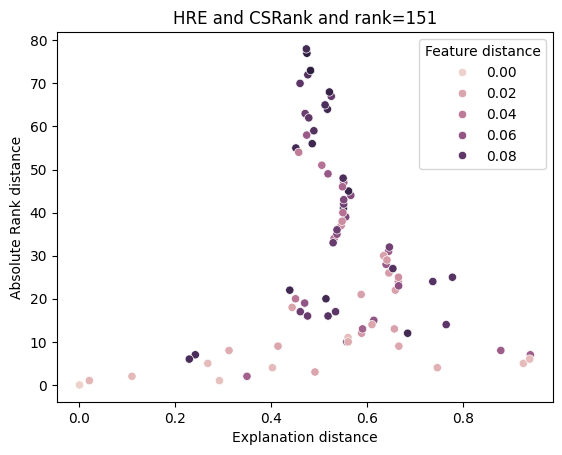

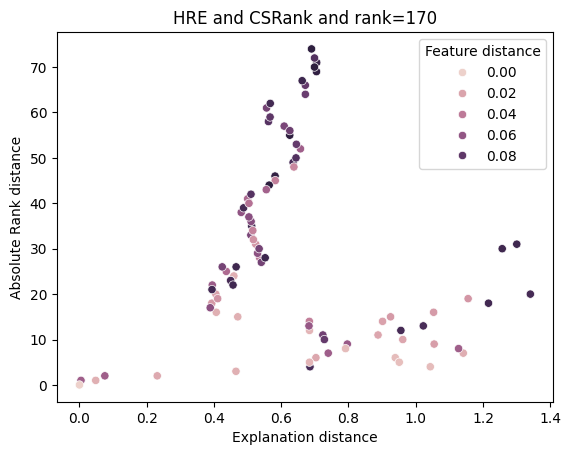

1397


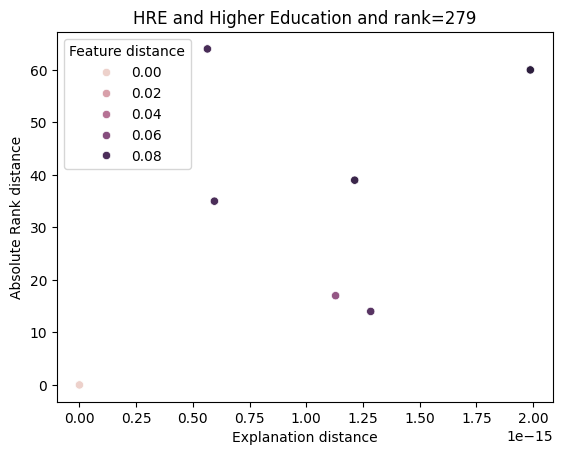

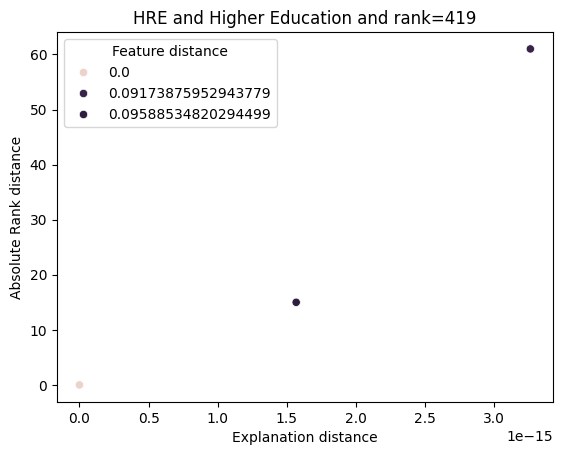

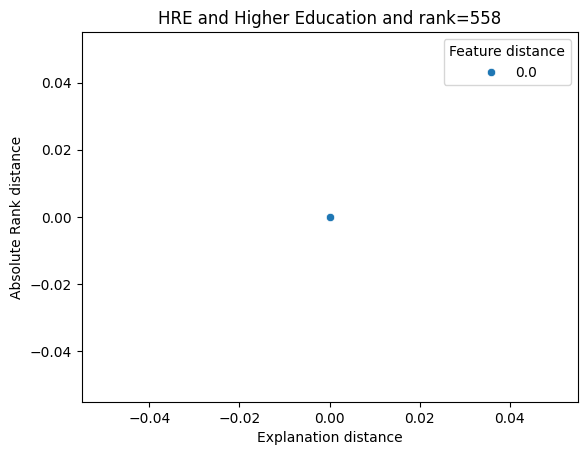

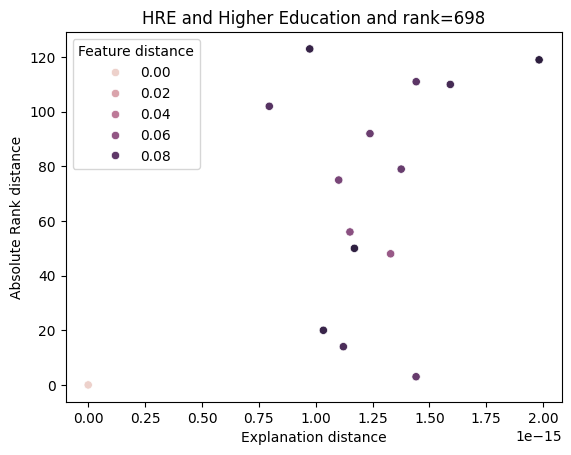

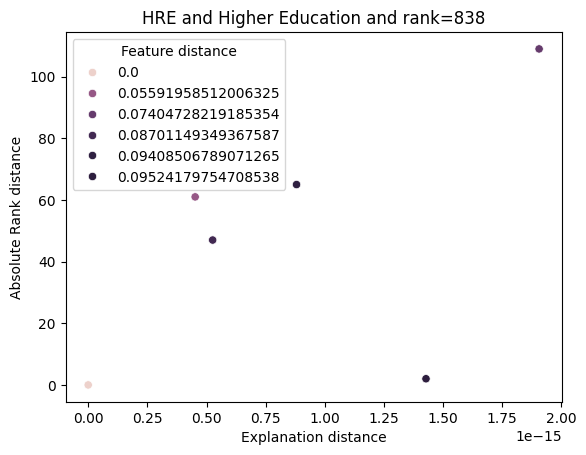

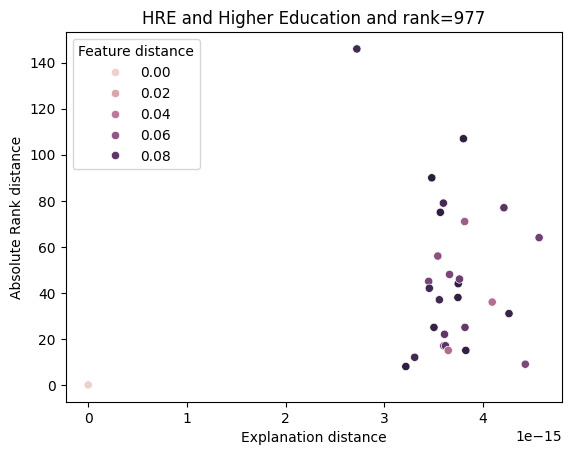

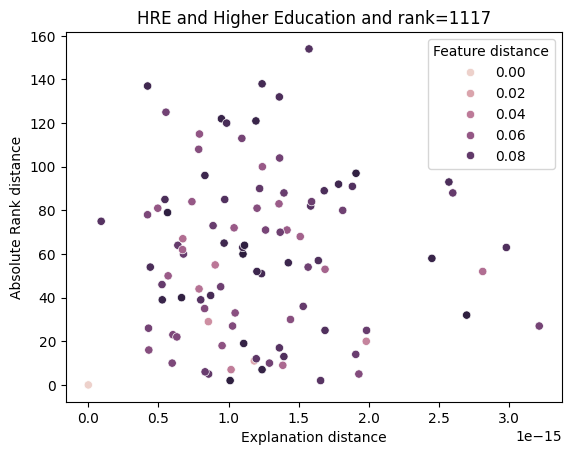

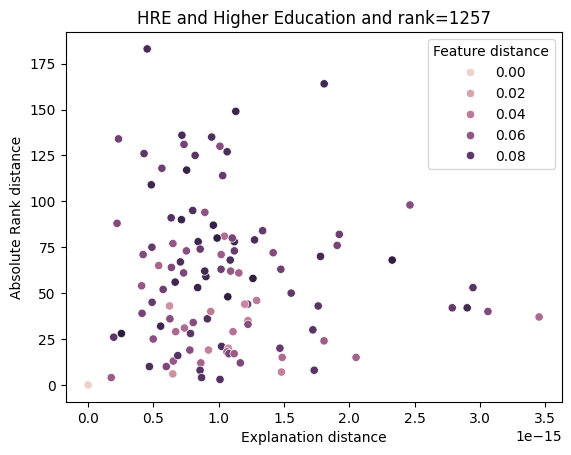

2000


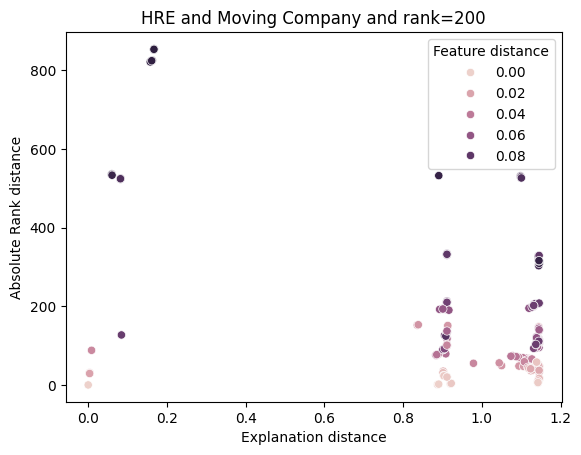

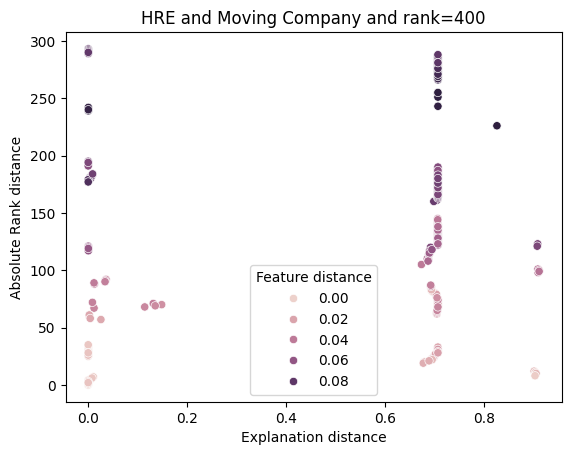

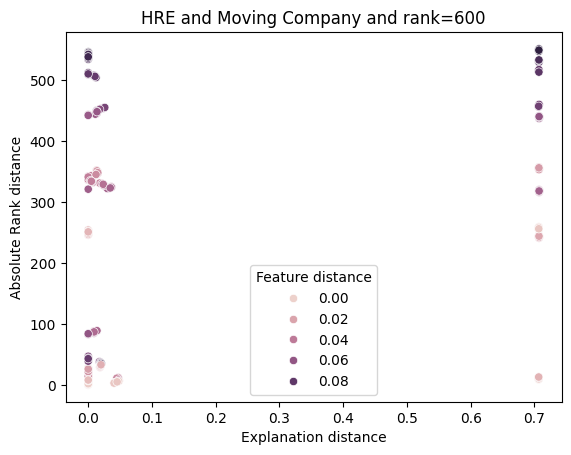

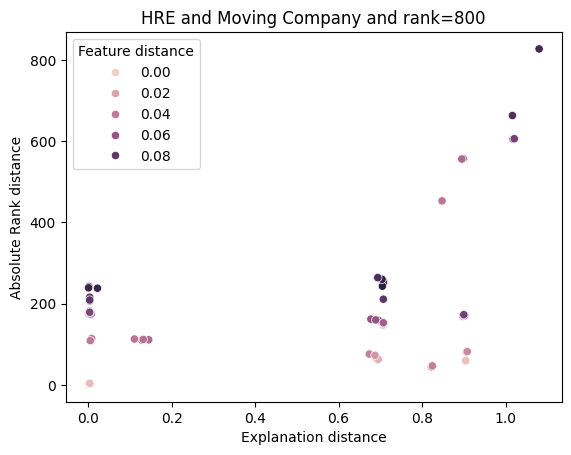

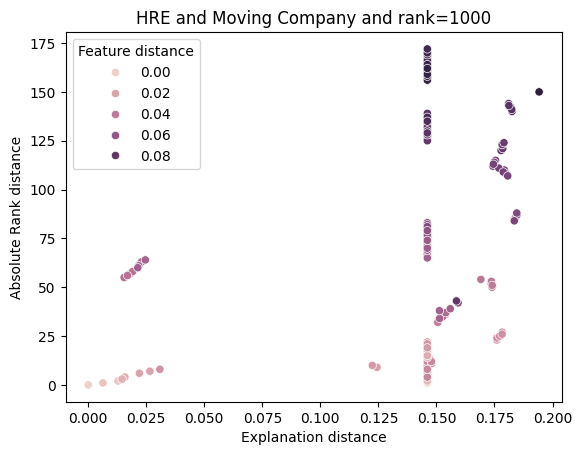

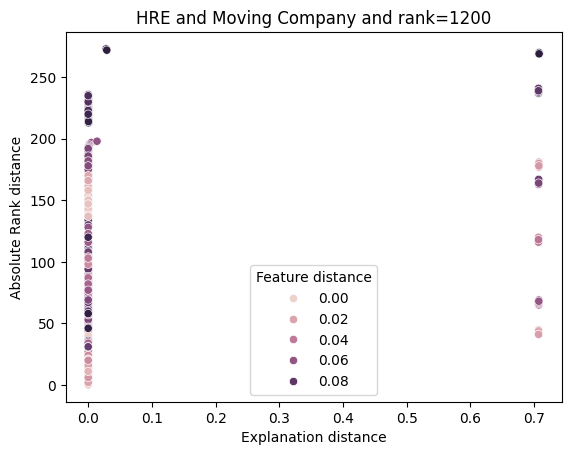

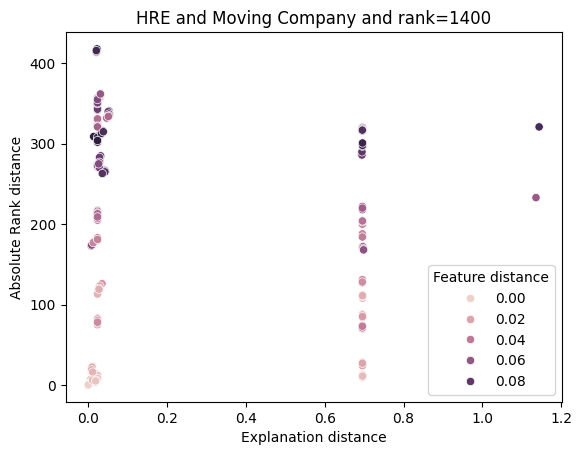

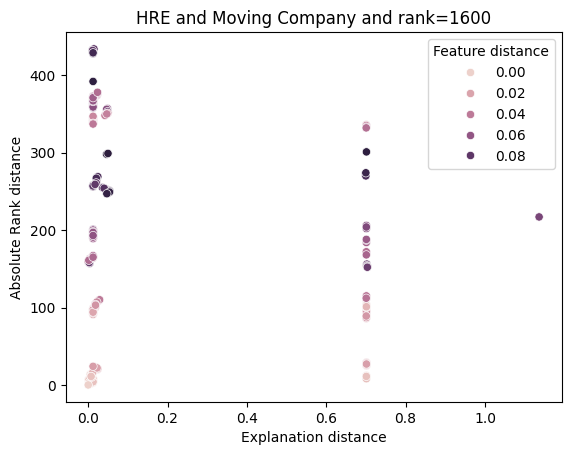

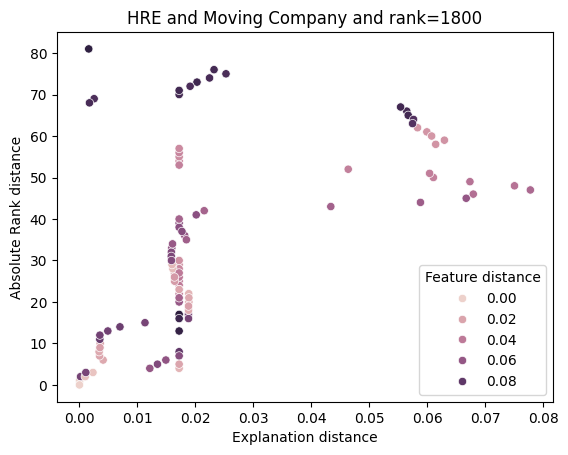

86


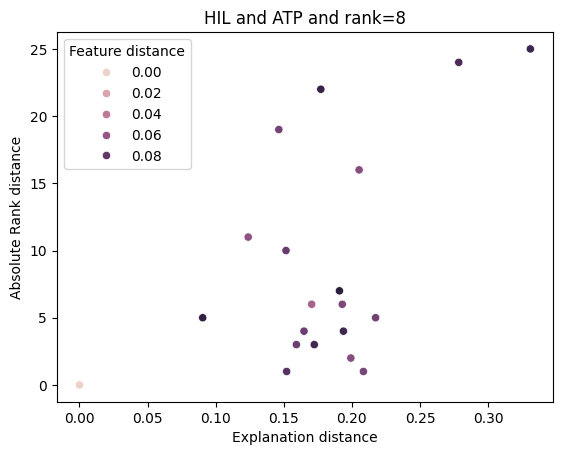

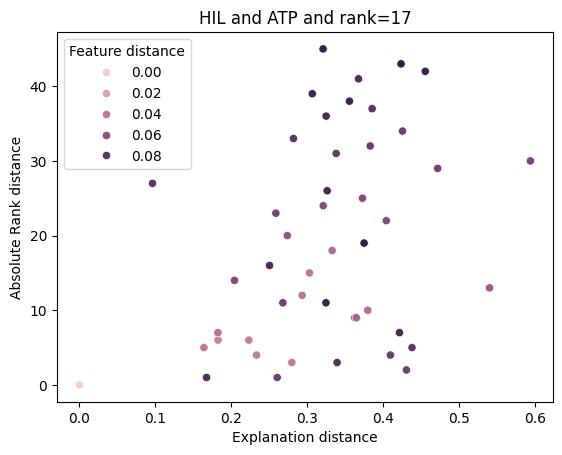

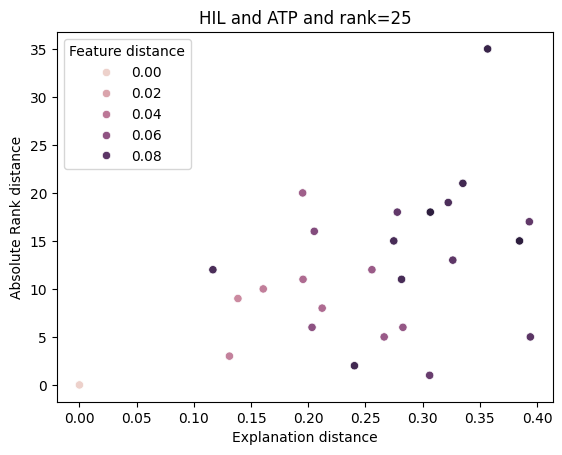

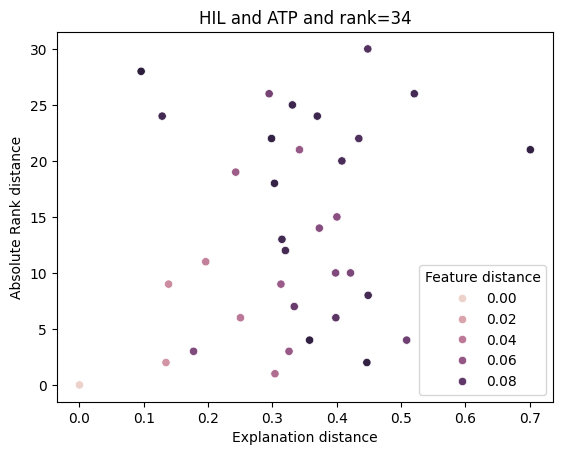

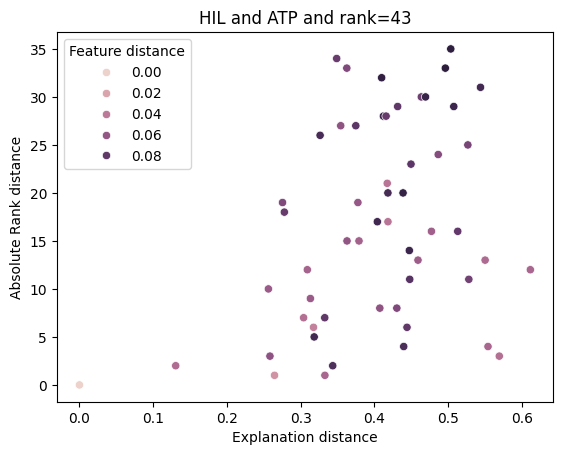

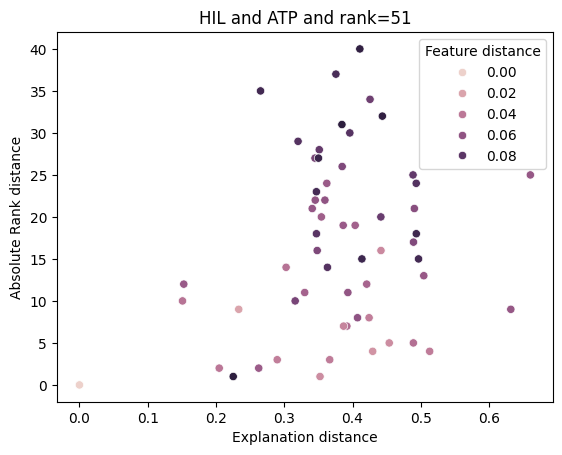

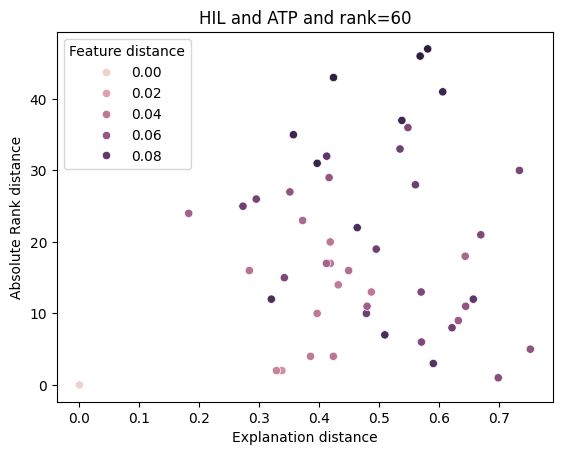

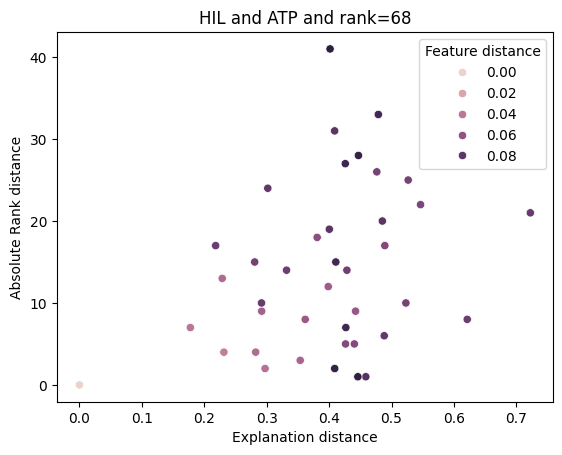

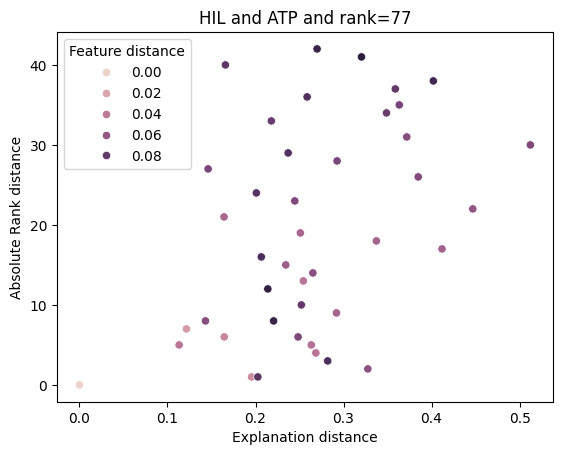

189


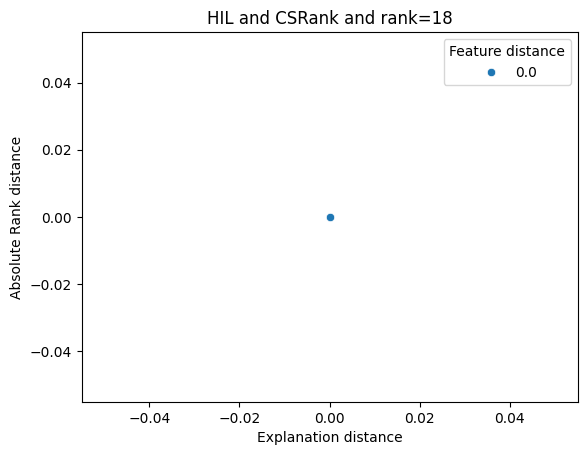

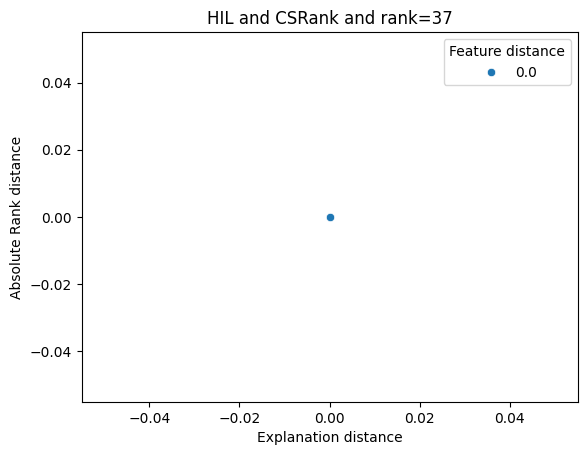

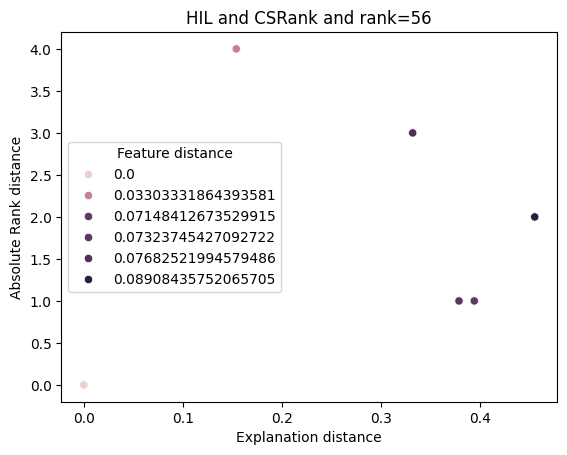

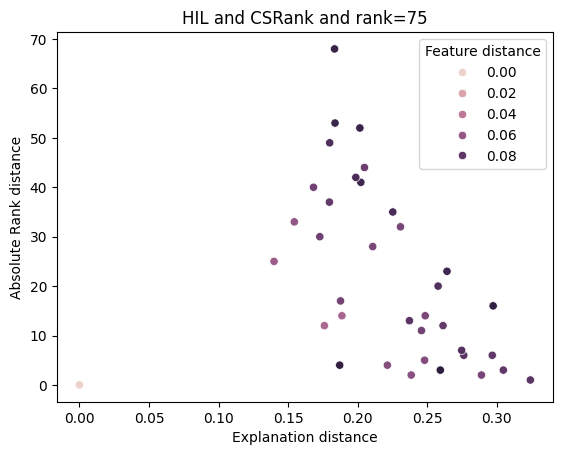

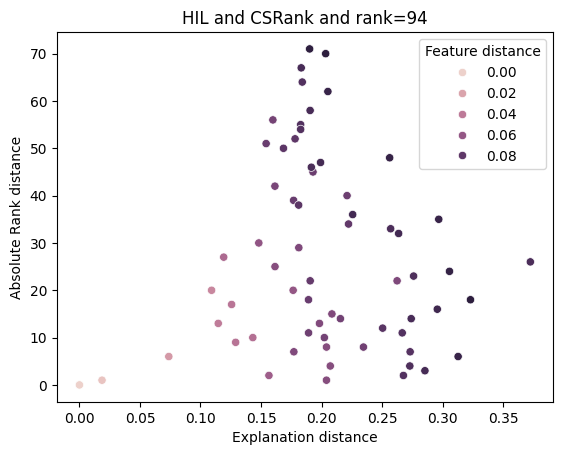

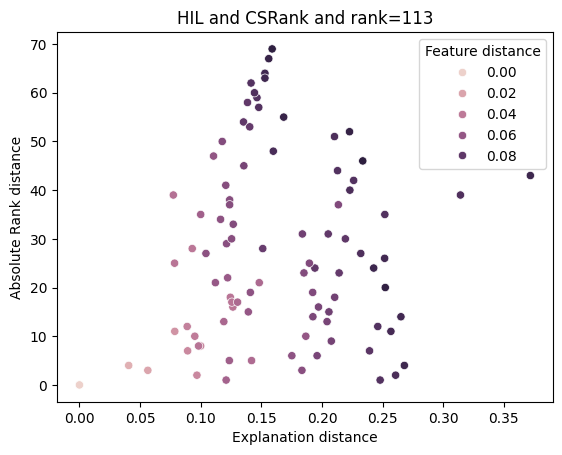

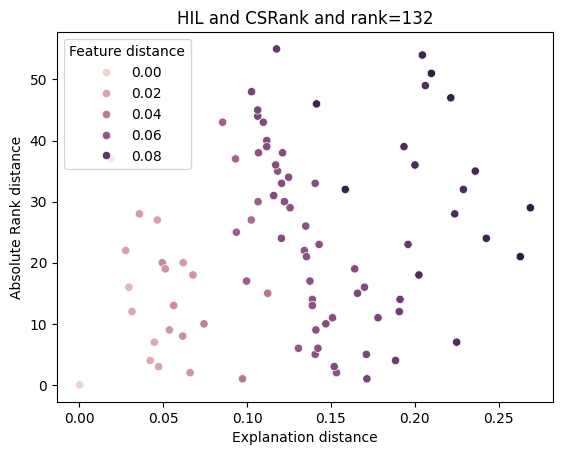

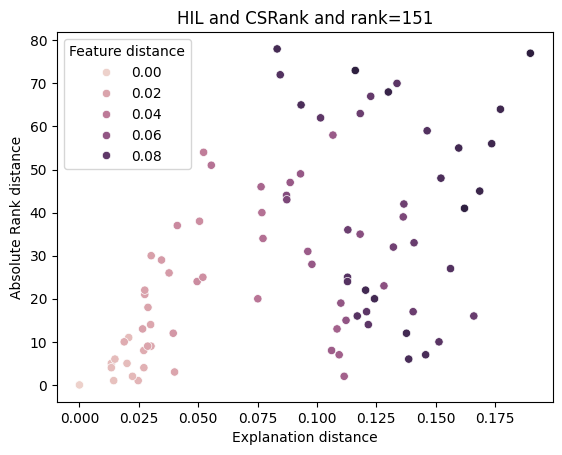

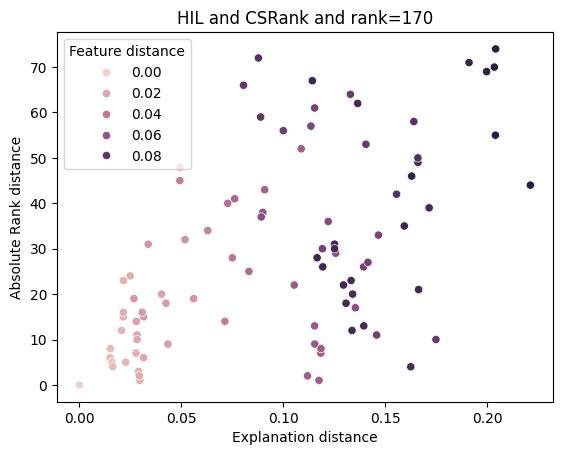

1397


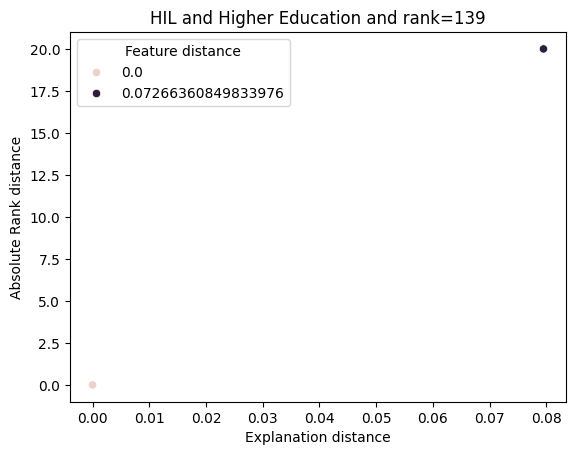

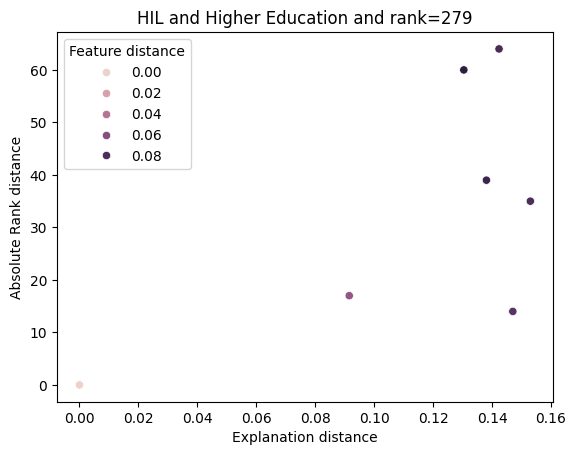

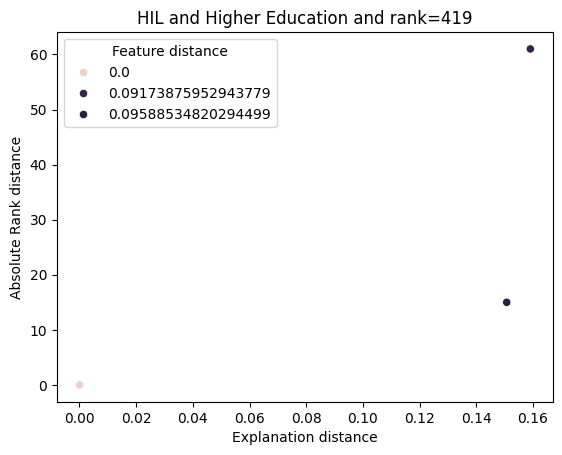

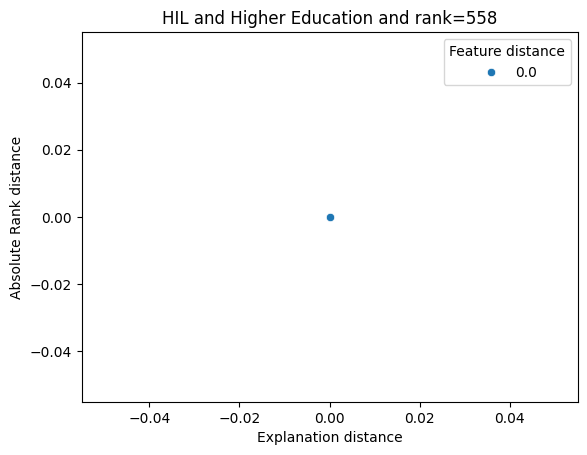

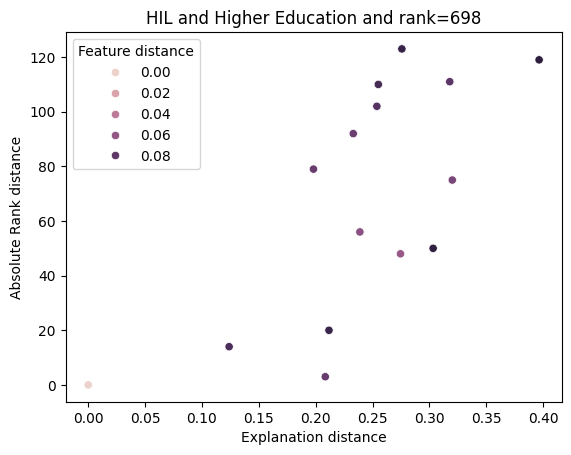

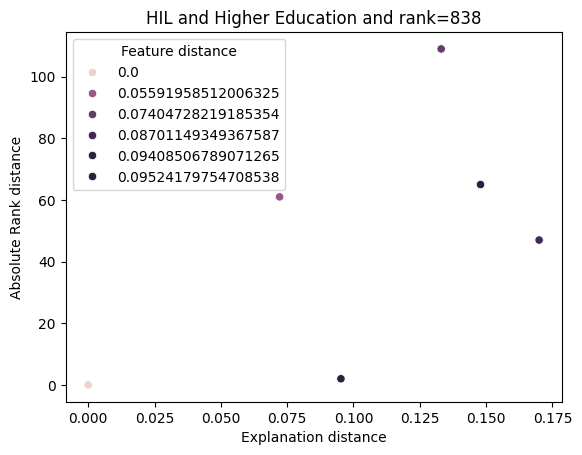

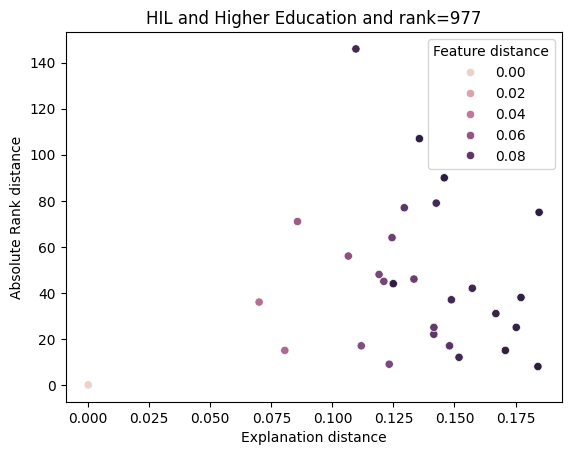

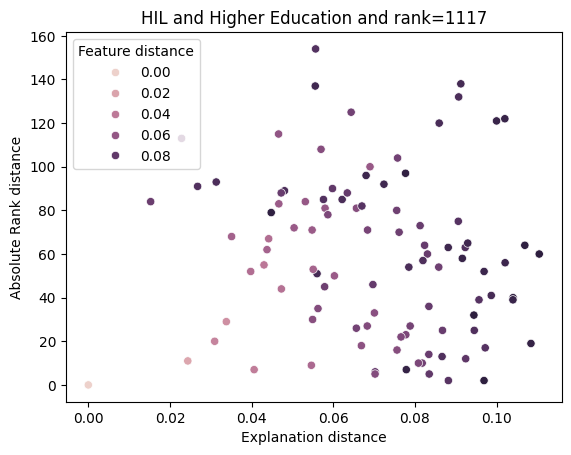

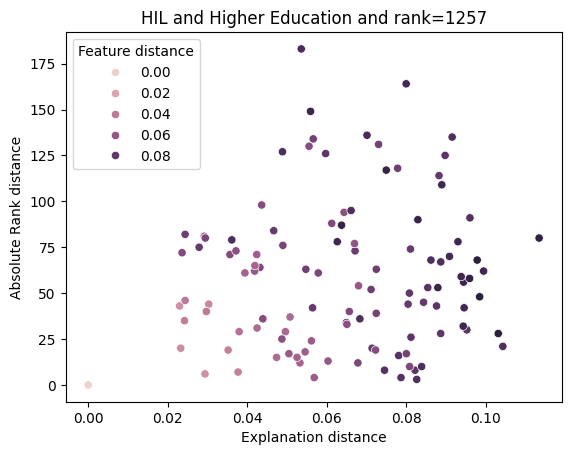

2000


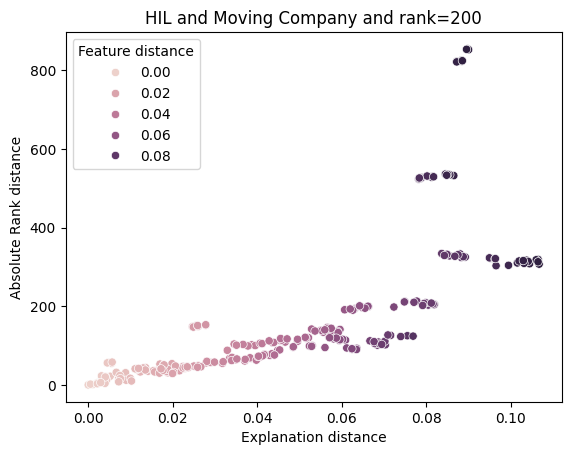

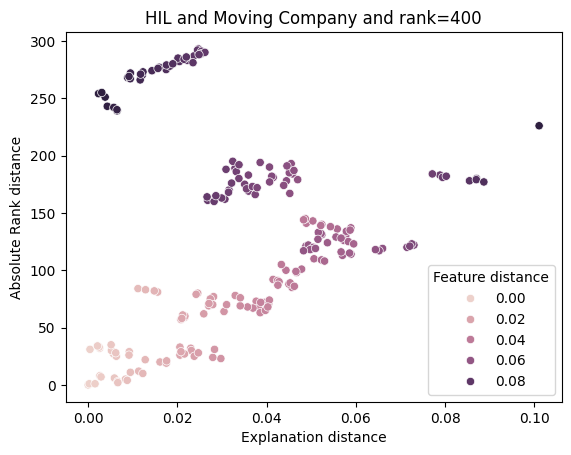

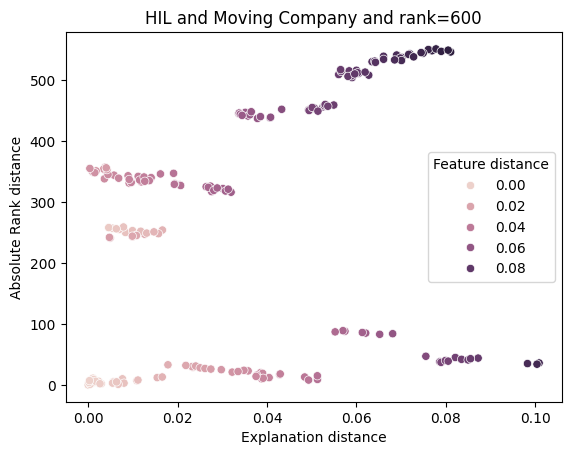

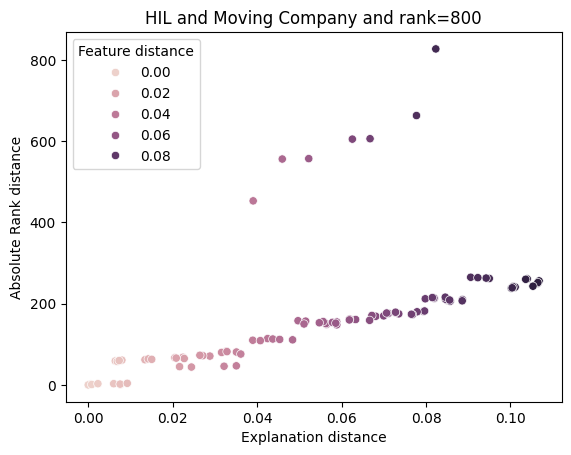

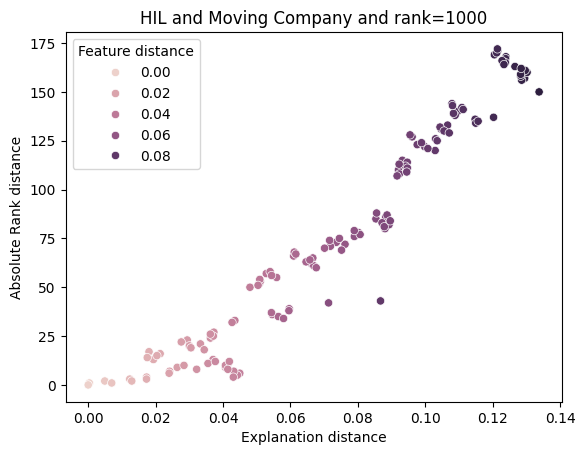

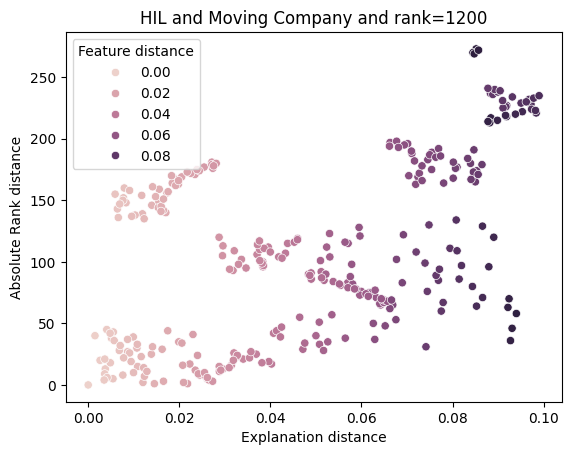

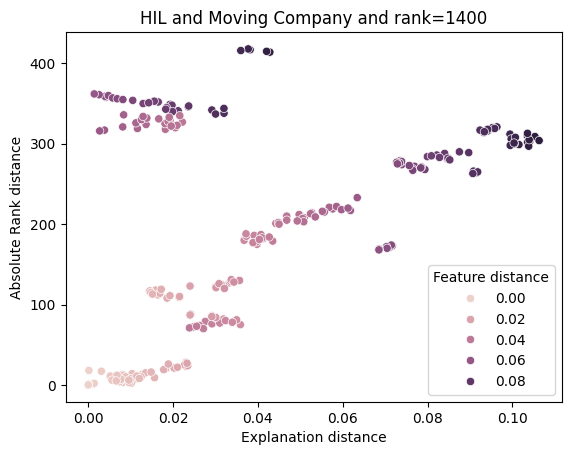

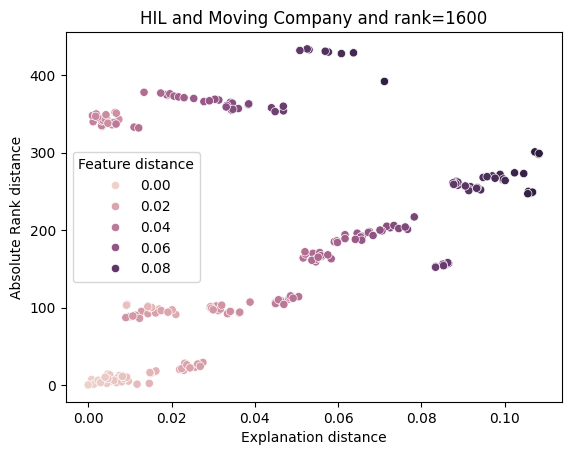

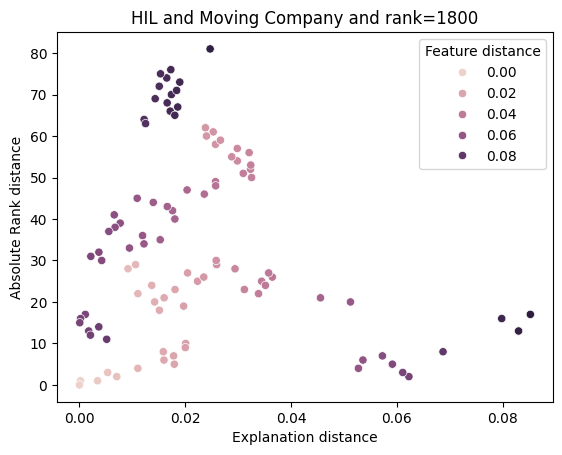

In [11]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

for method in methods:
    for dataset in datasets:
        rankings = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
        result = explanation_sensitivity_all_neighbors(
            dataset["data"][0], 
            results[dataset["name"]][method][0],
            rankings,
            measure="euclidean",
            #n_features=0.8,
            threshold=0.1
        )

        df_length = dataset['data'][0].shape[0]
        print(df_length)
        for plot_idx in [int(num/10*df_length) for num in range(1,10,1)]:
            measure_distances, rank_distances, feature_distances = result(row_idx=plot_idx)
    
            temp = pd.DataFrame()
    
            temp['Explanation distance'] = measure_distances
            temp['Absolute Rank distance'] = np.absolute(rank_distances)
            temp['Feature distance'] = feature_distances
            sns.scatterplot(data=temp, x="Explanation distance", y="Absolute Rank distance", hue="Feature distance")
            plt.title(f'{method} and {dataset["name"]} and rank={plot_idx}')
    
            plt.savefig(
            f"results/sensitivity-scatterplot-{dataset["name"]}-{method}-{plot_idx}.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True
            )
            
            plt.show()


# Outcome Sensitivity

In [7]:
help(outcome_sensitivity)

Help on function outcome_sensitivity in module xai_ranking.metrics._sensitivity:

outcome_sensitivity(original_data, score_func, contributions, threshold=0.8, n_neighbors=10, n_tests=10, std_multiplier=0.2, aggregate_results=False, random_state=None)



In [8]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

out_sens_res = {}
out_sens_sem = {}
for method in methods:
    out_sens_res[method] = {}
    out_sens_sem[method] = {}
    for dataset in datasets:
        try:
            rankings = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
            result = outcome_sensitivity(
                dataset["data"][0],
                dataset["scorer"],
                results[dataset["name"]][method][0],
                threshold=0.8,
                n_neighbors=10,
                n_tests=10,
                std_multiplier=0.2,
                aggregate_results=True,
                random_state=RNG_SEED,
            )
            out_sens_res[method][dataset["name"]] = result[0]
            out_sens_sem[method][dataset["name"]] = result[1]
        except:
            pass

In [9]:
pd.DataFrame(out_sens_res)

HRE        HIL
ATP                 5.771163   5.797442
CSRank              9.498042  12.471799
Higher Education    5.498790  24.790759
Moving Company    110.541105  60.826725

# Explanation Consistency

In [7]:
help(cross_method_explanation_consistency)

Help on function cross_method_explanation_consistency in module xai_ranking.metrics._consistency:

cross_method_explanation_consistency(results1, results2, measure='kendall', **kwargs)



In [8]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

exp_cons_res = {}
exp_cons_sem = {}
for dataset in datasets:
    exp_cons_res[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    exp_cons_sem[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    for method1, method2 in product(methods, methods):
        try:
            result = cross_method_explanation_consistency(
                results[dataset["name"]][method1][0], results[dataset["name"]][method2][0], measure="kendall"
            )

            exp_cons_res[dataset["name"]].loc[method1, method2] = result[0]
            exp_cons_sem[dataset["name"]].loc[method1, method2] = result[1]
        except:
            pass

In [9]:
exp_cons_res

{'ATP':            LIME      SHAP     ShaRP       HRE       HIL
 LIME        0.0  0.092248  0.095349  0.529457  0.530233
 SHAP   0.092248       0.0  0.034109  0.531783  0.535659
 ShaRP  0.095349  0.034109       0.0  0.530233  0.546512
 HRE    0.529457  0.531783  0.530233       0.0  0.406977
 HIL    0.530233  0.535659  0.546512  0.406977       0.0,
 'CSRank':            LIME      SHAP     ShaRP       HRE       HIL
 LIME        0.0  0.098942  0.164021  0.540741  0.489947
 SHAP   0.098942       0.0  0.177249  0.577249  0.487302
 ShaRP  0.164021  0.177249       0.0  0.435979  0.541799
 HRE    0.540741  0.577249  0.435979       0.0  0.572487
 HIL    0.489947  0.487302  0.541799  0.572487       0.0,
 'Higher Education':            LIME      SHAP     ShaRP       HRE       HIL
 LIME        0.0  0.093629  0.106084   0.57466  0.520329
 SHAP   0.093629       0.0  0.087616  0.592699  0.493701
 ShaRP  0.106084  0.087616       0.0  0.525698  0.555261
 HRE     0.57466  0.592699  0.525698       0.0   

In [20]:
avg_exp_cons_res = pd.DataFrame(columns=methods, index=methods).fillna(0)
for dataset, res_ in exp_cons_res.items():
    # if dataset != "Moving Company":
        # avg_exp_cons_res += res_
    avg_exp_cons_res += res_

avg_exp_cons_res /= len(datasets)
avg_exp_cons_res

/state/partition1/job-48610969/ipykernel_3047864/1798256637.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_exp_cons_res = pd.DataFrame(columns=methods, index=methods).fillna(0)


LIME      SHAP     ShaRP       HRE       HIL
LIME        0.0   0.13308  0.100114  0.486881  0.535169
SHAP    0.13308       0.0  0.130702  0.483724  0.467499
ShaRP  0.100114  0.130702       0.0  0.446061  0.555018
HRE    0.486881  0.483724  0.446061       0.0  0.481873
HIL    0.535169  0.467499  0.555018  0.481873       0.0

# Outcome Consistency

In [23]:
help(cross_method_outcome_consistency)

Help on function cross_method_outcome_consistency in module xai_ranking.metrics._consistency:

cross_method_outcome_consistency(original_data, score_func, contributions1, contributions2, threshold=0.8, n_tests=10, std_multiplier=0.2, random_state=None)



In [24]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

out_cons_res = {}
out_cons_sem = {}
for dataset in datasets:
    out_cons_res[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    out_cons_sem[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    for method1, method2 in product(methods, methods):
        try:
            result = cross_method_outcome_consistency(
                dataset["data"][0], dataset["scorer"],
                results[dataset["name"]][method1][0],
                results[dataset["name"]][method2][0], 
                random_state=RNG_SEED 
            )

            out_cons_res[dataset["name"]].loc[method1, method2] = result[0]
            out_cons_sem[dataset["name"]].loc[method1, method2] = result[1]
        except:
            pass

In [25]:
out_cons_res["Higher Education"]

avg_out_cons_res = pd.DataFrame(columns=methods, index=methods).fillna(0)
for dataset, res_ in out_cons_res.items():
    # if dataset != "Moving Company":
    #     avg_out_cons_res += res_
    avg_out_cons_res += res_

avg_out_cons_res /= len(datasets)
avg_out_cons_res

/state/partition1/job-48619443/ipykernel_1262558/393677172.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_out_cons_res = pd.DataFrame(columns=methods, index=methods).fillna(0)


LIME        SHAP       ShaRP         HRE         HIL
LIME          0.0   14.109855   14.335095  120.802684   19.590852
SHAP    14.109855         0.0   18.323358  117.781884    23.09982
ShaRP   14.335095   18.323358         0.0  114.851029   22.210148
HRE    120.802684  117.781884  114.851029         0.0  122.788285
HIL     19.590852    23.09982   22.210148  122.788285         0.0

# Bootstrapped Consistency

In [37]:
help(bootstrapped_explanation_consistency)

Help on function bootstrapped_explanation_consistency in module xai_ranking.metrics._consistency:

bootstrapped_explanation_consistency(population_result, batch_results, measure='kendall', **kwargs)



In [40]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

boot_cons_res = {}
boot_cons_sem = {}
for method in methods:
    boot_cons_res[method] = {}
    boot_cons_sem[method] = {}
    for dataset in datasets:
        try:
            result = bootstrapped_explanation_consistency(
                results[dataset["name"]][method][0], results[dataset["name"]][f"BATCH_{method}"],
                measure="kendall"
            )
            boot_cons_res[method][dataset["name"]] = result[0]
            boot_cons_sem[method][dataset["name"]] = result[1]
        except:
            pass

/scratch/vp724/xAI-Ranking-Benchmark/xai_ranking/metrics/_consistency.py:18: RuntimeWarning: Mean of empty slice.
  mean = batch_agreement.mean()
/ext3/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/ext3/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/ext3/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/ext3/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [41]:
pd.DataFrame(boot_cons_res)

LIME      SHAP     ShaRP       HRE       HIL
ATP               0.196357  0.090543  0.056357  0.317364  0.164574
CSRank            0.127778  0.070688  0.046455  0.190688  0.171746
Higher Education  0.090165  0.036807  0.016242  0.147609  0.069277
Moving Company    0.014750  0.213667       NaN  0.139667  0.000000

In [8]:
def plot_dataset_aggregated_summary(agg_mean, agg_sem, gap=0.3):
    n_cols = len(agg_mean.columns)
    x = np.arange(n_cols).astype(np.float64)

    methods = agg_mean.index.unique()
    bars = len(methods)
    bar_width = (1 - gap) / bars
    x -= (bars - 1) * bar_width / 2

    for method in methods:
        plt.errorbar(
            x,
            agg_mean.loc[method],
            yerr=agg_sem.loc[method],
            marker="o",
            label=method,
            linestyle="None",
        )
        x += bar_width
    plt.legend()
    plt.xticks(np.arange(n_cols), agg_mean.columns, rotation=45)

Could not find a LaTeX installation. ``text.usetex`` will be set to False.


Error in dataset: Moving Company, with method: ShaRP


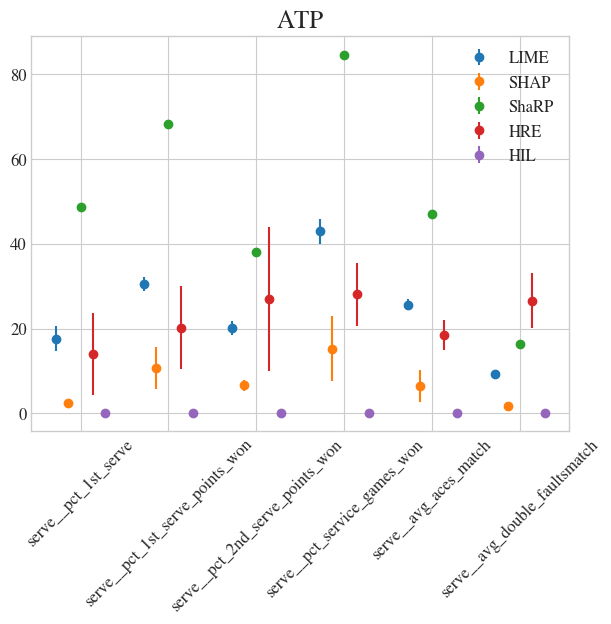

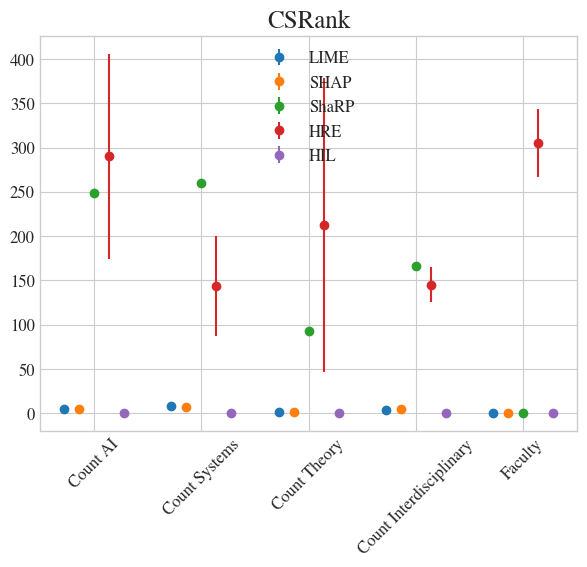

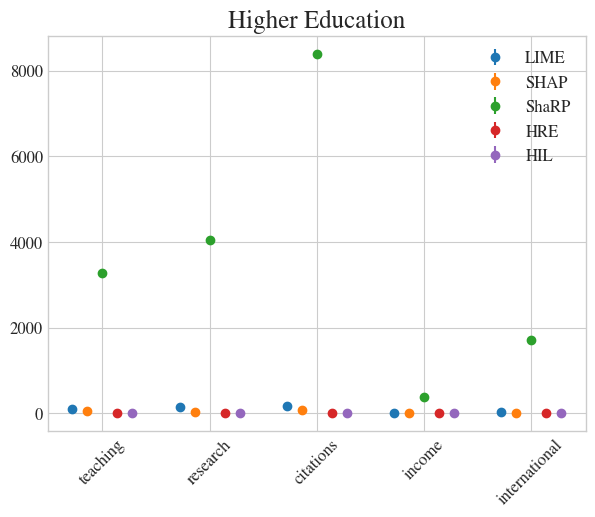

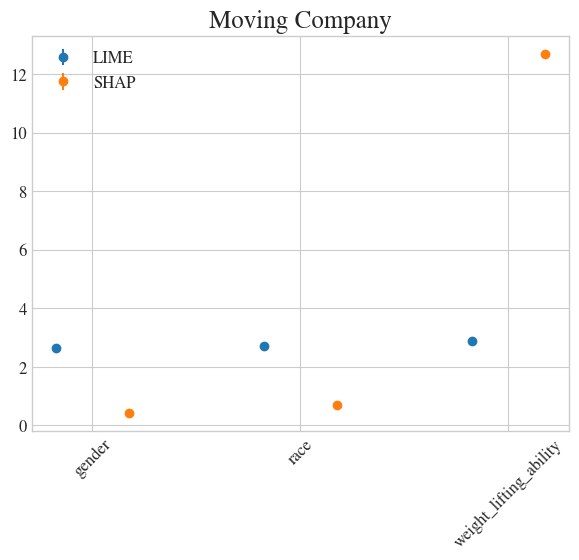

In [9]:
set_matplotlib_style(font_size=12, **{"font.family": ["Nimbus Roman"]})
aggregated_summary, aggregated_error = compute_all_stability(results, axis=0)
for dataset in aggregated_summary:
    plot_dataset_aggregated_summary(
        aggregated_summary[dataset], aggregated_error[dataset]
    )
    plt.title(dataset)
    plt.show()

# Agreement

In [10]:
agreement_results = compute_all_agreement(results, n_features=3)
agreement_results["ATP"]["kendall"]

Error in dataset: Moving Company, with methods: LIME, ShaRP
Error in dataset: Moving Company, with methods: LIME, HRE
Error in dataset: Moving Company, with methods: LIME, HIL
Error in dataset: Moving Company, with methods: SHAP, ShaRP
Error in dataset: Moving Company, with methods: SHAP, HRE
Error in dataset: Moving Company, with methods: SHAP, HIL
Error in dataset: Moving Company, with methods: ShaRP, LIME
Error in dataset: Moving Company, with methods: ShaRP, SHAP
Error in dataset: Moving Company, with methods: ShaRP, ShaRP
Error in dataset: Moving Company, with methods: ShaRP, HRE
Error in dataset: Moving Company, with methods: ShaRP, HIL
Error in dataset: Moving Company, with methods: HRE, LIME
Error in dataset: Moving Company, with methods: HRE, SHAP
Error in dataset: Moving Company, with methods: HRE, ShaRP
Error in dataset: Moving Company, with methods: HRE, HRE
Error in dataset: Moving Company, with methods: HRE, HIL
Error in dataset: Moving Company, with methods: HIL, LIME
Er

LIME      SHAP     ShaRP       HRE       HIL
LIME        1.0  0.804651  0.790698       0.0 -0.062016
SHAP   0.804651       1.0  0.933333  0.003101 -0.071318
ShaRP  0.790698  0.933333       1.0  0.020155  -0.07907
HRE         0.0  0.003101  0.020155       1.0  0.156589
HIL   -0.062016 -0.071318  -0.07907  0.156589       1.0

In [11]:
agreement_results["ATP"]["jaccard"]

LIME      SHAP     ShaRP       HRE       HIL
LIME        1.0  0.886047  0.868605  0.359302   0.39186
SHAP   0.886047       1.0  0.947674   0.35814  0.402326
ShaRP  0.868605  0.947674       1.0  0.355814  0.398837
HRE    0.359302   0.35814  0.355814       1.0  0.390698
HIL     0.39186  0.402326  0.398837  0.390698       1.0

In [12]:
agreement_results["CSRank"]["kendall"]

LIME      SHAP     ShaRP       HRE       HIL
LIME        1.0   0.78836  0.685714 -0.065608  0.008466
SHAP    0.78836       1.0  0.649735 -0.154497  0.025397
ShaRP  0.685714  0.649735       1.0  0.128042 -0.085714
HRE   -0.065608 -0.154497  0.128042       1.0 -0.144974
HIL    0.008466  0.025397 -0.085714 -0.144974       1.0

In [13]:
agreement_results["CSRank"]["jaccard"]

LIME      SHAP     ShaRP       HRE       HIL
LIME        1.0  0.841799  0.806878  0.455026  0.426455
SHAP   0.841799       1.0  0.788889  0.436508  0.439153
ShaRP  0.806878  0.788889       1.0  0.569841  0.414286
HRE    0.455026  0.436508  0.569841       1.0   0.39418
HIL    0.426455  0.439153  0.414286   0.39418       1.0

In [14]:
agreement_results["Higher Education"]["kendall"]

LIME      SHAP     ShaRP       HRE       HIL
LIME        1.0   0.81446  0.797423 -0.147459 -0.044381
SHAP    0.81446       1.0  0.825483 -0.187545  0.012598
ShaRP  0.797423  0.825483       1.0  -0.04796 -0.114102
HRE   -0.147459 -0.187545  -0.04796       1.0  0.041947
HIL   -0.044381  0.012598 -0.114102  0.041947       1.0

# Sensitivity

In [15]:
sensitivity_results = compute_all_sensitivity(
    original_data=datasets, 
    results=results, 
    n_neighbors=10
)

Error in dataset: Moving Company, with method: ShaRP
Error in dataset: Moving Company, with method: HRE
Error in dataset: Moving Company, with method: HIL


In [16]:
pd.DataFrame(sensitivity_results[0])

ATP    CSRank  Higher Education  Moving Company
HIL    0.260000 -0.040529          0.146127             NaN
HRE    0.353798  0.767937          0.712770             NaN
LIME   0.169767  0.536614          0.377409        0.556167
SHAP   0.130543  0.603280          0.358969        0.805500
ShaRP  0.167597  0.446984          0.326142             NaN

# Fidelity

In [17]:
fidelity_results = compute_all_fidelity(
    original_data=datasets, 
    results=results, 
    random_state=RNG_SEED
)
pd.DataFrame(fidelity_results[0])

Error in dataset: Moving Company, with method: ShaRP
Error in dataset: Moving Company, with method: HRE
Error in dataset: Moving Company, with method: HIL


ATP    CSRank  Higher Education  Moving Company
LIME   1.660202  5.802080         17.611022       73.761219
SHAP   1.724879  4.185789         18.012614      277.032029
ShaRP  1.768822  6.423129         20.269573             NaN
HRE    1.567466  6.539259         10.781634             NaN
HIL    1.724879  9.066170         24.860514             NaN

In [20]:
pd.DataFrame(fidelity_results[0]).mean(1)# .drop(columns="Moving Company").mean(1)

LIME     24.708631
SHAP     75.238828
ShaRP     9.487175
HRE       6.296120
HIL      11.883854
dtype: float64

In [57]:
# Score to rank plots

import seaborn as sns

for dataset in datasets:
    print(dataset["name"])
    df = pd.DataFrame()
    df['rank'] = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
    if dataset["name"] == "ATP":
        df['score'] = dataset["scorer"](dataset["data"][0]).values
    else:
        df['score'] = dataset["scorer"](dataset["data"][0])
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3), sharey='row')
    ax = sns.lineplot(data=df, x="rank", y="score", linewidth = 7, c='#66c2a5')
    ax.set_ylabel("score")
    ax.set_xlabel("rank")

    fig.savefig(
    f"results/rank-vs-score-linechart-{dataset["name"]}.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
    )

    plt.show()
    
        

ATP


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpiul3eds8 9e67ace2901c803a0e865b119c3cee5c.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./9e67ace2901c803a0e865b119c3cee5c.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/mathptmx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.10 \usepackage
                [utf8]{inputenc}^^M
No pages of output.
Transcript written on tmpiul3eds8/9e67ace2901c803a0e865b119c3cee5c.log.




Error in callback <function _draw_all_if_interactive at 0x1541fa3b2a20> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp53s567g2 9e67ace2901c803a0e865b119c3cee5c.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./9e67ace2901c803a0e865b119c3cee5c.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/mathptmx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.10 \usepackage
                [utf8]{inputenc}^^M
No pages of output.
Transcript written on tmp53s567g2/9e67ace2901c803a0e865b119c3cee5c.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpx06kqylp 9e67ace2901c803a0e865b119c3cee5c.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./9e67ace2901c803a0e865b119c3cee5c.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/mathptmx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.10 \usepackage
                [utf8]{inputenc}^^M
No pages of output.
Transcript written on tmpx06kqylp/9e67ace2901c803a0e865b119c3cee5c.log.




<Figure size 600x300 with 1 Axes>